# Assignment 2 Project A: Colon Cancer Image Classification

# 1. Approach

## Setup & Imports

In [4]:

import os
import random
from pathlib import Path
from itertools import cycle


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize


import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Metric, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory paths
main = '../Image_classification_data/data_labels_mainData.csv'
extra = '../Image_classification_data/data_labels_extraData.csv'
img_dir = '../Image_classification_data/patch_images'


## 1.1 Data Exploration and Understanding

### Class Imbalance Identification

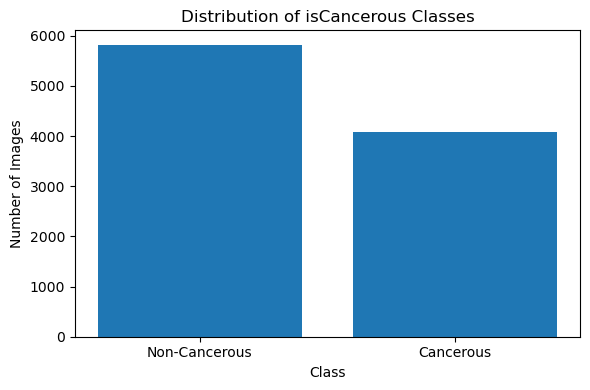

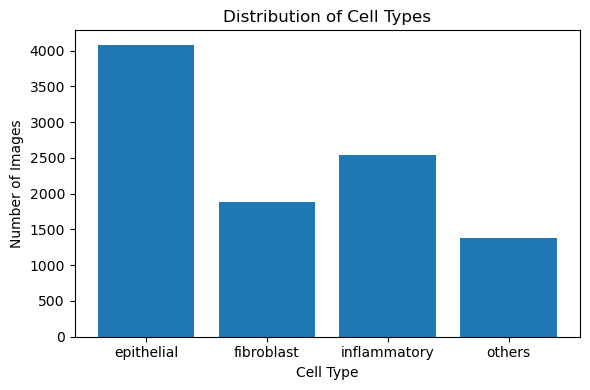

In [6]:
df_main = pd.read_csv(main)
df_extra = pd.read_csv(extra)

counts = df_main['isCancerous'].value_counts().sort_index()

class_names = ['Non-Cancerous', 'Cancerous']
counts.index = class_names

plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values)
plt.title('Distribution of isCancerous Classes')
plt.xlabel('Class')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

counts = df_main['cellTypeName'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values)
plt.title('Distribution of Cell Types')
plt.xlabel('Cell Type')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

- The above represents the class imbalances for isCancerous and cellTypeName, visualised through the bar graphs. The isCancerous class shows a clear imbalance in the count, as there are ~50% more non-cancerous compared to the cancerous.
- As for the cell types there is a clear disparancy between the **epithelial** cells and the rest, having twice the count compared to **fibroblast** and **others**. Also, being ~60% greater than the **inflammatory** cell.
- The difference in the count would lead to misleading accuracy towards the non-cancerous as it represents the majority of data and epithelial for the cell types. For data with fewer cases, models would tend to have low recall as there may not be enough information to be able to tell features apart leadning to worse generalisation.  



### Exploratory Data Analysis (EDA)

In [9]:
df_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [10]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In [11]:
df_main.isna()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
9891,False,False,False,False,False,False
9892,False,False,False,False,False,False
9893,False,False,False,False,False,False
9894,False,False,False,False,False,False


**Oberservations**
- The data is clean and well structured, and has no null values.
- Each of the rows has a unique ImageName and InstanceID.
- cellType is multiclass integer type and the assosiated names are listed in cellTypeName.
- isCancerous is a binary target and is an integer variable.

In [13]:
# 1. Check for missing labels in the main data set
print("Missing isCancerous labels:", df_main['isCancerous'].isnull().sum())
print("Missing cellType labels:", df_main['cellType'].isnull().sum())

# 2. Inspect unique values
print("Unique isCancerous values:", df_main['isCancerous'].unique())
print("Unique cellType values:", df_main['cellType'].unique())

Missing isCancerous labels: 0
Missing cellType labels: 0
Unique isCancerous values: [0 1]
Unique cellType values: [0 1 3 2]


- The code above highlights the missing labels for both isCancerous and cellType. However, as observered there are no missing labels, therefore there is no need for any additional data handling methods for missing labels.

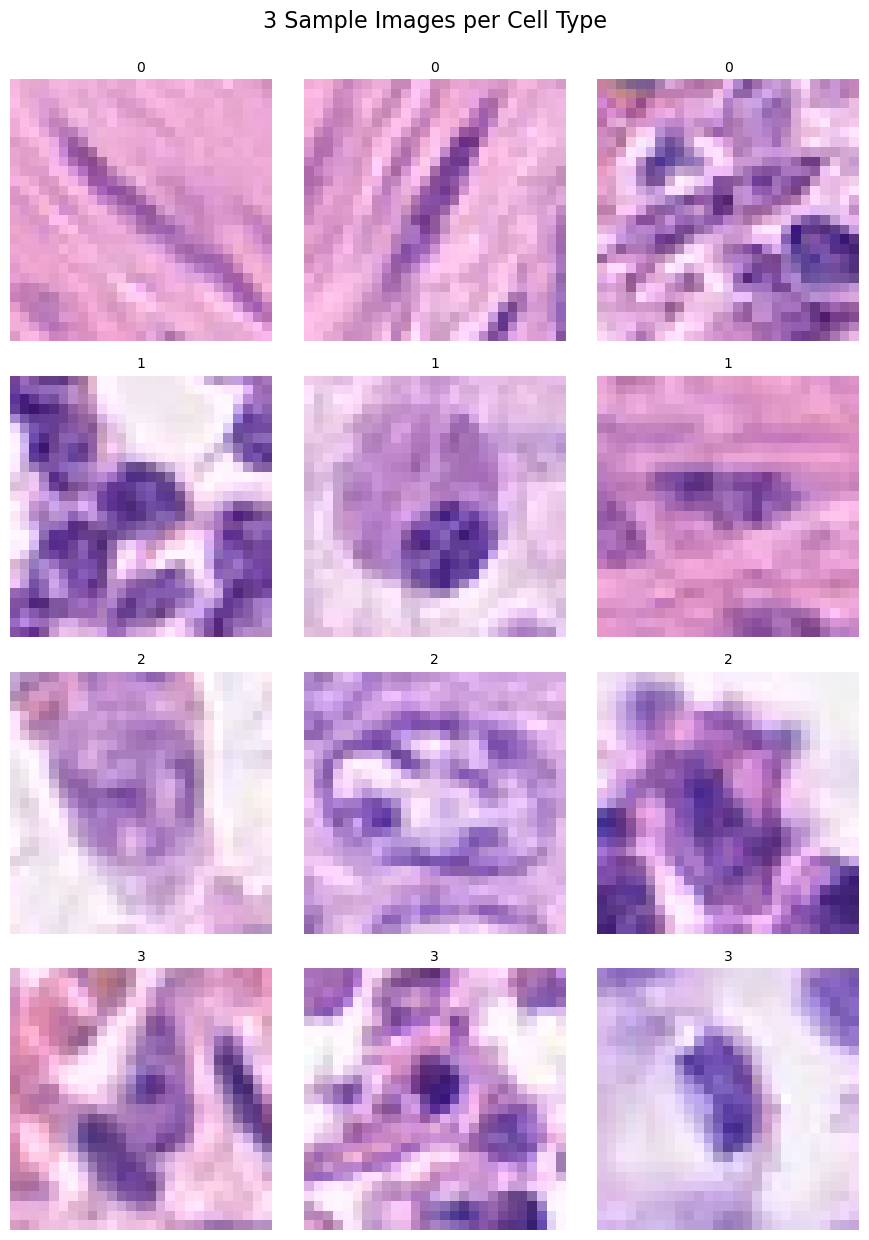

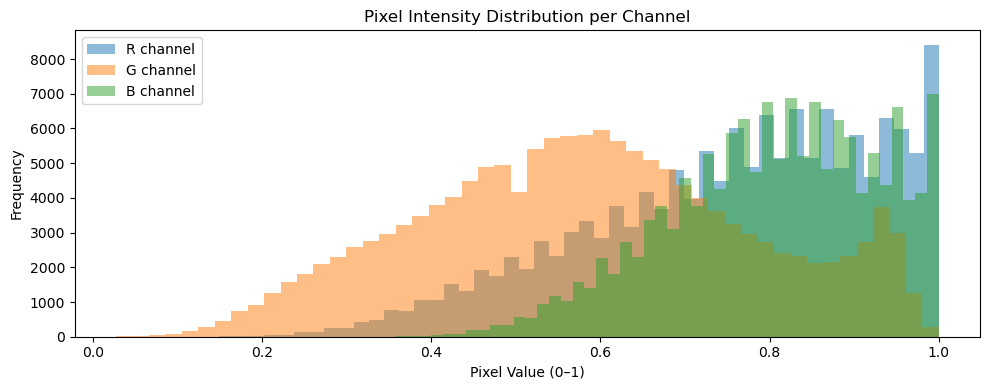

,Channel,Mean,Std Dev
0,R,0.754753,0.169548
1,G,0.584671,0.196201
2,B,0.803542,0.122828


In [15]:

# 1. Create list of image filenames
all_names = df_main['ImageName'].astype(str).unique().tolist()

# 2. Directory containing image patches
img_dir = Path('../Image_classification_data/patch_images')

# 3. Sample-Image Grid (up to 3×3)
# Ensure labels are strings
df_main['cellType'] = df_main['cellType'].astype(str)

# Sample settings
samples_per_class = 3
cell_types = sorted(df_main['cellType'].unique())

# Plotting grid
n_rows = len(cell_types)
n_cols = samples_per_class
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

# Handle single row case
if n_rows == 1:
    axes = [axes]

for i, cell_type in enumerate(cell_types):
    # Get 3 random images for this cell type
    sample_rows = df_main[df_main['cellType'] == cell_type].sample(n=samples_per_class, random_state=42)
    
    for j, img_name in enumerate(sample_rows['ImageName']):
        img_path = os.path.join(img_dir, img_name)
        img = mpimg.imread(img_path)
        ax = axes[i][j] if n_rows > 1 else axes[j]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{cell_type}", fontsize=10)

plt.tight_layout()
plt.suptitle("3 Sample Images per Cell Type", fontsize=16, y=1.03)
plt.show()

# 4. Pixel-Intensity Histograms (per channel)
m = min(len(all_names), 200)
hist_names = random.sample(all_names, m)
hist_arr = np.stack([
    (mpimg.imread(img_dir / name) / 255.0) if mpimg.imread(img_dir / name).dtype == np.uint8
    else mpimg.imread(img_dir / name)
    for name in hist_names
])

plt.figure(figsize=(10, 4))
channels = ['R', 'G', 'B']
for idx, col in enumerate(channels):
    plt.hist(hist_arr[..., idx].ravel(), bins=50, alpha=0.5, label=f'{col} channel')
plt.legend()
plt.title("Pixel Intensity Distribution per Channel")
plt.xlabel("Pixel Value (0–1)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 5. Channel Mean & Std Dev
means = hist_arr.mean(axis=(0, 1, 2))
stds = hist_arr.std(axis=(0, 1, 2))
stats_df = pd.DataFrame({
    'Channel': channels,
    'Mean': means,
    'Std Dev': stds
})
stats_df


- Some cell images show occlusion due to overlapping tissue, which can make feature extraction difficult; rotation and zoom augmentation help the model learn from different visible regions.
- Blurry or unfocused samples caused by microscope capture issues reduce clarity. Brightness and contrast augmentation improves the model’s robustness to such variations.
- A few images contain embedded text or corner labels that introduce irrelevant features; random cropping and zooming prevent the model from overfitting to these fixed positions.
- The RGB pixel intensity distribution is imbalanced, with the red and blue channels dominating and the green channel underrepresented.
- Most pixel values fall in the higher range (0.6–1.0), limiting contrast and reducing texture visibility in dark or shadowed regions.
- The model might learn to depend on colors instead of real cell shapes, which can hurt performance.
- Data augmentation strategies like flipping, rotating, zooming, and color jittering enhance the model’s ability to generalize across different imaging conditions and improve prediction reliability.

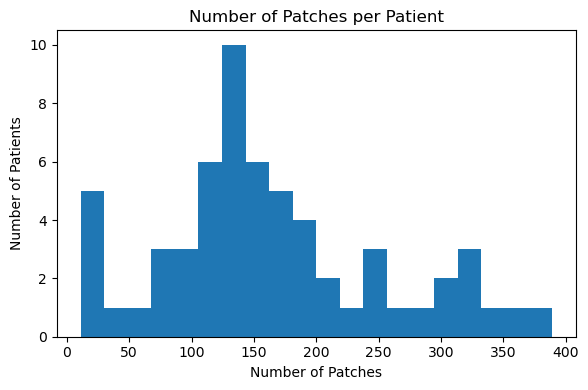

In [17]:
counts_patient = df_main['patientID'].value_counts()

plt.figure(figsize=(6, 4))
plt.hist(counts_patient, bins=20)
plt.title('Number of Patches per Patient')
plt.xlabel('Number of Patches')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()

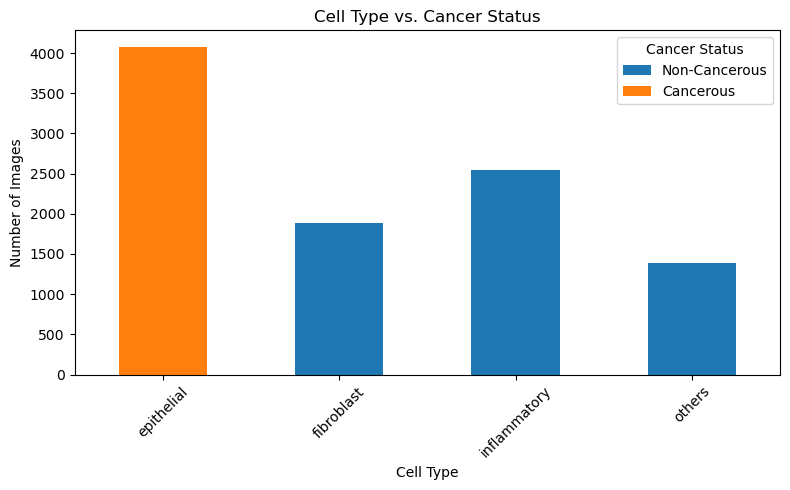

In [18]:
# Mapping numeric codes to names
type_mapping = {
    0: 'fibroblast',
    1: 'inflammatory',
    2: 'epithelial',
    3: 'others'
}
df_main['cellType'] = df_main['cellType'].astype(int)  # ensure it's numeric
df_main['cellTypeName'] = df_main['cellType'].map(type_mapping)


crosstab = pd.crosstab(df_main['cellTypeName'], df_main['isCancerous'])
crosstab.columns = ['Non-Cancerous', 'Cancerous']

# Stacked bar 
ax = crosstab.plot(kind='bar', stacked=True, figsize=(8, 5))
ax.set_xlabel('Cell Type')            
ax.set_ylabel('Number of Images')
ax.set_title('Cell Type vs. Cancer Status')
plt.xticks(rotation=45)
plt.legend(title='Cancer Status')
plt.tight_layout()
plt.show()

### Justification of Data Handling Methods

**Normalization**
- All the images were rescaled to [0,1] range using the rescale=1/255 in the ImageDataGenerator.  
- By normalisating it allows convergence to occur faster and more stably when inputs are in a small. It also prevents large gradients that can destabilize the training.

**Class Weighting**
- By computing the weights for both the isCancerous and cellType using sk.learn.utils.class_weight.
- Class weighting allows to compensate the difference in count of the classes by increase the penalty on missclassifications of the minority class, which improves the models fairness and therefore the predictive performance across both classes.

**Oversampling**
- Oversampling is done by duplicating the samples from the minority classes to match the size of the majority class.
- This balances the class distribution and prevents the model from being bias towards the majority class. This improves the models ability to pick up on edge cases, and improves the recall and F1-score.

**Image Augmentation**
- Techniques such as horizontal flipping, random rotation, and zooming can be applied using ImageDataGenerator.
- Image augmentation can increase the diversity of the data without the need for collecting new data, therefore helps the model in being able to generalise better to unseen data. This would fix the issues with the images outlined in the EDA.

**Early Stopping**
- By monitoring the validation performance metrics and to stop the training of the model once the performance stops improving.
- This saves time by not overtraining the model and avoids overfitting keeping the best model.

## 1.2 Evaluation Framework 
### Performance Metrics Selection

- **Precision** treats each of the classes equally by averaging the class precision, ensures that miniorty classes are not affected by the class imbalance. Reduces the overly accurate predictions of the majority class.
- **Recall** treats each class with an equal weight, detecting only the true instance of the rare classes, reducing the number of false negatvies. Recall leads the model to focus on the minority classes.
- **F1-Score** as the mean of both the precision and recall averaged equally, it strikes a balance between the precision and recall across the various classes. Increases both the accuracy and better representation of minority classes like both preicision and recall.
  
**Note**: F1-score will not be used for the visualisation but will be taken into account when considering a models performance through the use of the classification report for the final models.

### Data Splitting Strategy & Prevention of Data Leakage

In [24]:
patient_ids = df_main['patientID'].unique()

train_pats, test_pats = train_test_split(
    patient_ids,
    test_size=0.20,
    random_state=42
)

train_pats, val_pats = train_test_split(
    train_pats,
    test_size=0.25,
    random_state=42
)

# 4. Filter the DataFrame by patientID for each split
train_data = df_main[df_main['patientID'].isin(train_pats)]
val_data   = df_main[df_main['patientID'].isin(val_pats)]
test_data  = df_main[df_main['patientID'].isin(test_pats)]

print("Train data : {}, Val data: {}, Test data: {}".format(
    train_data.shape[0],
    val_data.shape[0],
    test_data.shape[0]
))

Train data : 5774, Val data: 2283, Test data: 1839


-  The train-validation-test split divides the data into 60/20/20 balances the training data with dedicated validation and test data sets. Ensuring, that there is no overfitting and bias generalisations made by the model. Also, makes use of the random_state = 42 to ensure that each rerun of the code produces the same splits.
-  It is important to avoid the patient-based data leakage, as the same patient may appear across the different splits which can cause the model to "memorise" patient specific patterns rahter than learning about the disease patterns. Cuase for high accuracy score which would not carry on with new patients (poor generalisation).
-  To prevent this, group splitting by using the patientID column. This can be done through scikit-learns GroupShuffleSplit or GroupKfold, to ensure that all the patients data are exclusively within each of the folds.
- Consistency checks whereby the model may be trained on patient subsets and comapred to common validation set, to monitor if the performance changes drastically hinting to leakage or specific dataset bias. 

## 1.3 Model Selection & Justification

### Base Model Selection and Justification

- Convolutional Neural Network (CNN) is able to discard redundant information from the images, transform the images into subsets of important features, further use the features for image recognition, and reduce the size/dime of the image. 
- MLP would be considered a good baseline as it is easy to implement and treats every pixel equally due to no spatial bias, and is useful as a benchmarking tool to be able to tell apart the performance increase to more advanced models such as CNNs.
- Comparing these to alternatives it, ANN would require more parameters to be able to learn the same features. SVM would be less flexible in capturing large datasets as there is a quadratic scaling in the traning time. 

In [28]:


# To ensure there is no warning that comes when runing the generators
train_data = train_data.copy()
val_data   = val_data.copy()
test_data  = test_data.copy()

train_data['isCancerous'] = train_data['isCancerous'].astype(str)
val_data['isCancerous']   = val_data['isCancerous'].astype(str)
test_data['isCancerous']  = test_data['isCancerous'].astype(str)

train_data['cellType'] = train_data['cellType'].astype(str)
val_data  ['cellType'] = val_data['cellType'].astype(str)
test_data ['cellType'] = test_data['cellType'].astype(str)

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen   = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen  = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

binary_train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=img_dir,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
binary_validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=img_dir,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
binary_test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=img_dir,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# 4. Multiclass generators for cell type
multi_train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=img_dir,
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
multi_validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=img_dir,
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
multi_test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=img_dir,
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 5774 validated image filenames belonging to 2 classes.
Found 2283 validated image filenames belonging to 2 classes.
Found 1839 validated image filenames belonging to 2 classes.
Found 5774 validated image filenames belonging to 4 classes.
Found 2283 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.


- The above code firstly implements input normalisation to rescale the pixel values which range from 0 to 25, to a scale of 0 to 1. The larger pixel values make the optimization process unstable and slow, espescially models that use gradient descent or a variant such as 'Adam'.
- Therefore, this allows the neural networks to converge fasters and more efficiently as the input features are within a smaller range. It also, ensures that activation function such as ReLU or sigmoid do not saturate due to larger values.
- Following the input normalisation, the generators are required for both isCancerous (binary) and cellType (multiclass) labels different output formats. The binary generators are used for a single-label output and the multiclass generators to generate one-hot-encoded labels which are suitable for multiclass softmax classification.

#### Function to plot learning curve

In [31]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='F1-score'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

#### Baseline Models
#### isCancerous CNN Baseline Model

C:\Users\azhar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


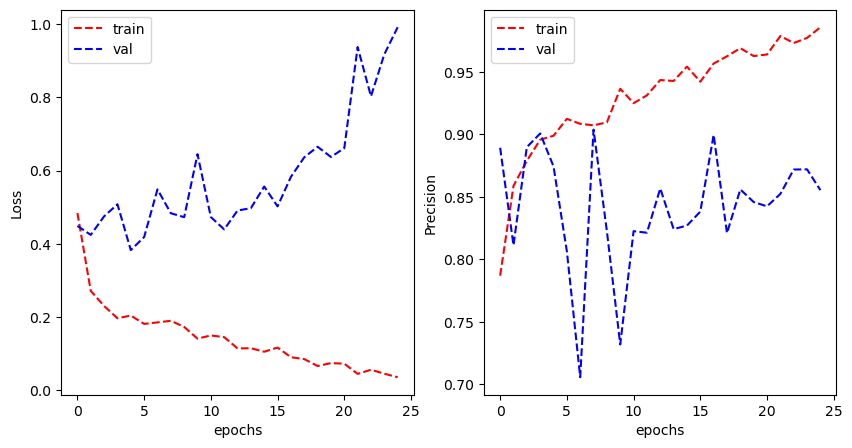

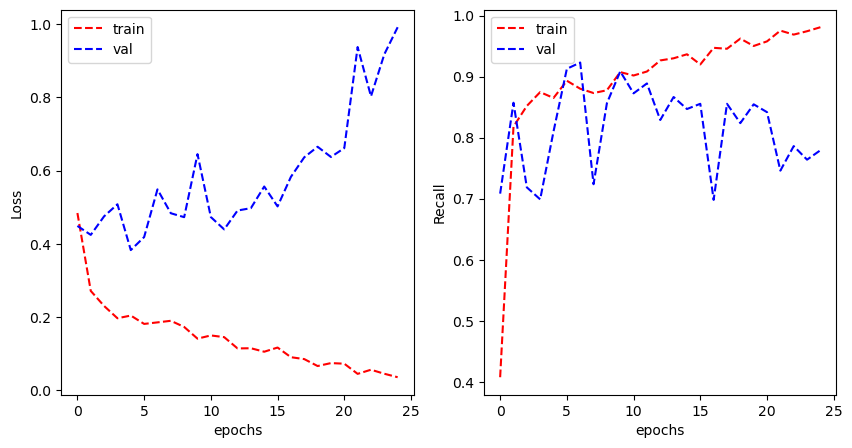

In [33]:

input_shape = (27, 27, 3)

cnn_baseline = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),

    # Block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
  #  tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

# Compile with precision and recall metrics
cnn_baseline.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        Precision(name='precision'),
        Recall(name='recall')
        #F1Score(name='f1_score')
    ]
)

# Train the model
history_cnn = cnn_baseline.fit(
    binary_train_generator,
    steps_per_epoch=len(binary_train_generator),
    validation_data=binary_validation_generator,
    validation_steps=len(binary_validation_generator),
    epochs=25,
    verbose=0
)

# Plot precision 
plot_learning_curve(
    history_cnn.history['loss'],
    history_cnn.history['val_loss'],
    history_cnn.history['precision'],        
    history_cnn.history['val_precision'],    
    metric_name='Precision'
)

# Recall
plot_learning_curve(
    history_cnn.history['loss'],
    history_cnn.history['val_loss'],
    history_cnn.history['recall'],
    history_cnn.history['val_recall'],
    metric_name='Recall'
)

#### isCancerous MLP Baseline Model

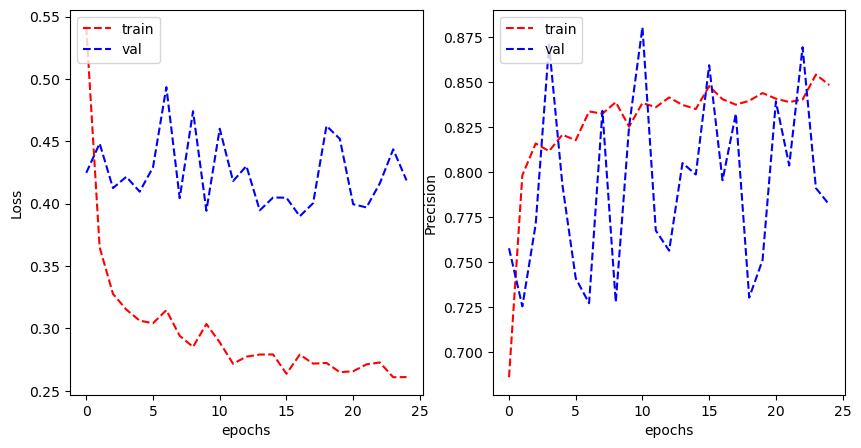

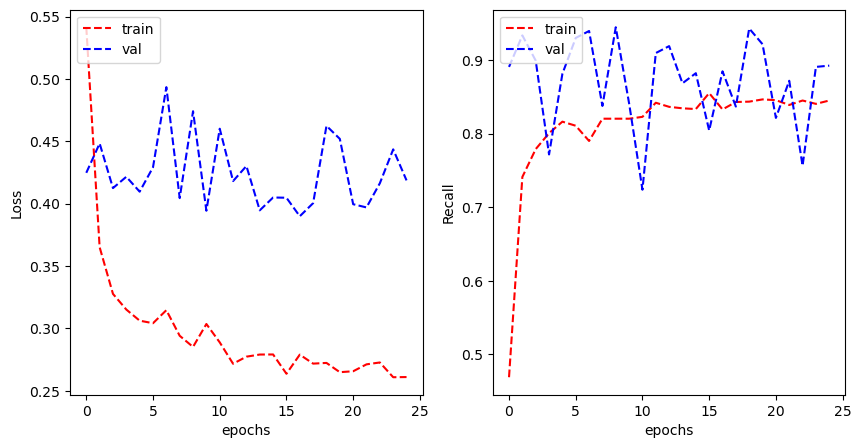

In [35]:
input_shape = (27, 27, 3)
mlp_binary = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
mlp_binary.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        Precision(name='precision'),
        Recall(name='recall'),
        #F1Score(name='f1_score')
    ]
)

# Train model
history_mlp_binary = mlp_binary.fit(
    binary_train_generator,
    validation_data=binary_validation_generator,
    epochs=25,
    verbose=0
)

# Precision
plot_learning_curve(
    history_mlp_binary.history['loss'],
    history_mlp_binary.history['val_loss'],
    history_mlp_binary.history['precision'],
    history_mlp_binary.history['val_precision'],
    metric_name='Precision'
)

# Recall
plot_learning_curve(
    history_mlp_binary.history['loss'],
    history_mlp_binary.history['val_loss'],
    history_mlp_binary.history['recall'],
    history_mlp_binary.history['val_recall'],
    metric_name='Recall'
)

- The CNN model uses three convolutional blocks (Conv2D + MaxPooling) with ReLU activations to extract spatial features from images, followed by a Flatten layer, a Dense layer for learning complex patterns, and a sigmoid output layer for binary classification. A Dropout layer (0.5) is used to reduce overfitting.
-The MLP model takes (27, 27, 3) images, flattens them directly into a 1D vector, and passes them through two Dense layers (256 and 128 units) with ReLU activations. It also includes a Dropout layer (0.5) and ends with a sigmoid output layer for binary classification.
- ReLU activation is used in all hidden layers to introduce non-linearity and improve training efficiency, while the sigmoid activation in the final layer maps output to a probability between 0 and 1, suitable for binary classification (isCancerous).
- Both models are compiled with the Adam optimizer for adaptive and efficient training, and binary crossentropy loss, which is the standard choice for binary classification as it measures the error between predicted and actual class probabilities.

#### Precision and Recall for Multiclass

In [38]:
class GlobalPrecision(tf.keras.metrics.Precision):
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert from one-hot to class indices
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

class GlobalRecall(tf.keras.metrics.Recall):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)


- The custom classes make the multiclass metrics (precision and recall) make it compatible with the Keras's API, which assumes that the labels are not one-hot-encoded.
- Without the conversion there would be incorrect metric results and cause errors during the training.

#### Cell Type CNN Baseline Model

x_batch shape: (32, 27, 27, 3)
y_batch shape: (32, 4)
num_classes from model: 4


C:\Users\azhar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


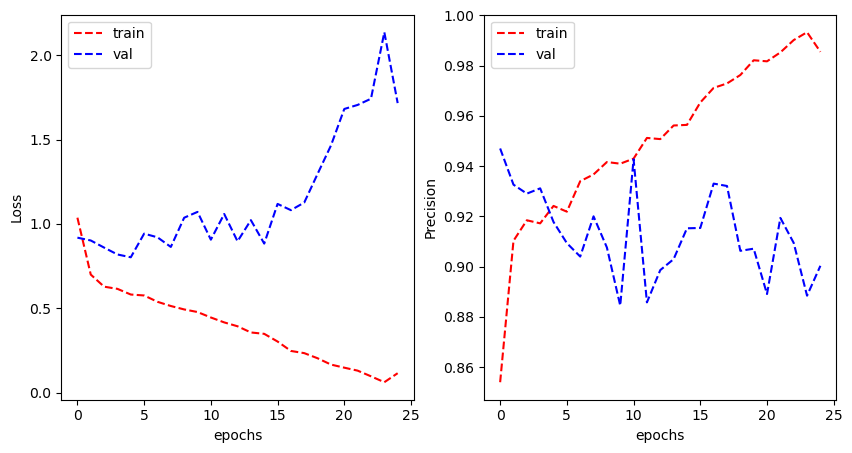

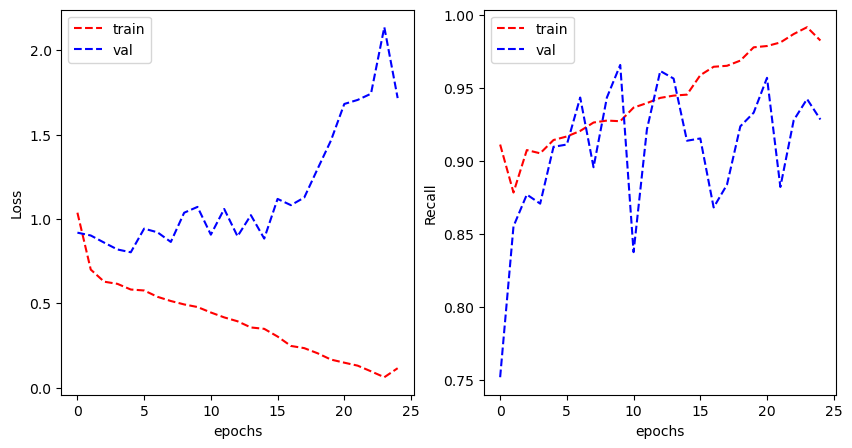

In [41]:
input_shape = (27, 27, 3)
# As it is a categorical variable requires unique number of classes
num_classes = len(train_data['cellType'].unique())

celltype_model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),

    # Block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
   # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

celltype_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        GlobalPrecision(name='precision'),
        GlobalRecall(name='recall')
    ]
)

#  history_celltype = celltype_model.fit(
#     multi_train_generator,
#     validation_data=multi_validation_generator,
#     epochs=25,
#     verbose=0
# )

x_batch, y_batch = next(iter(multi_train_generator))
print("x_batch shape:", x_batch.shape)  # should be (32, 27, 27, 3)
print("y_batch shape:", y_batch.shape)  # should be (32, num_classes)
print("num_classes from model:", num_classes)


history_celltype = celltype_model.fit(
    multi_train_generator,
    steps_per_epoch=len(multi_train_generator),
    validation_data=multi_validation_generator,
    validation_steps=len(multi_validation_generator),
    epochs=25,
    verbose=0
)


plot_learning_curve(
    history_celltype.history['loss'],
    history_celltype.history['val_loss'],
    history_celltype.history['precision'],
    history_celltype.history['val_precision'],
    metric_name='Precision'
)

plot_learning_curve(
    history_celltype.history['loss'],
    history_celltype.history['val_loss'],
    history_celltype.history['recall'],
    history_celltype.history['val_recall'],
    metric_name='Recall'
)

#### Cell Type MLP Baseline Model

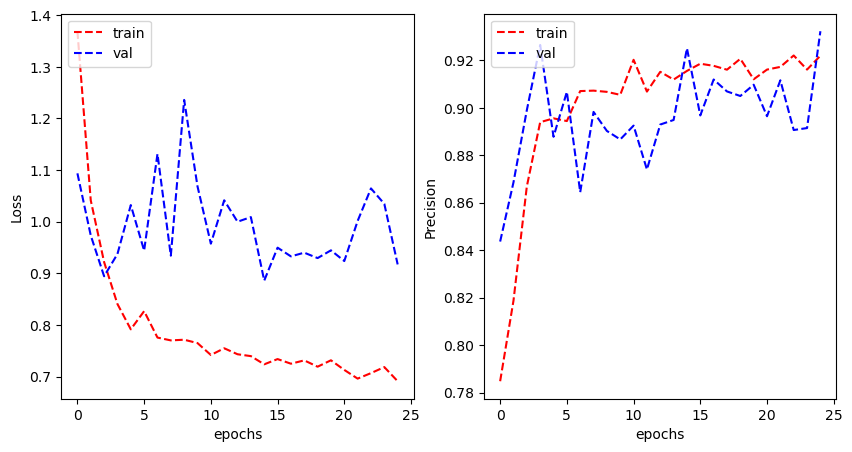

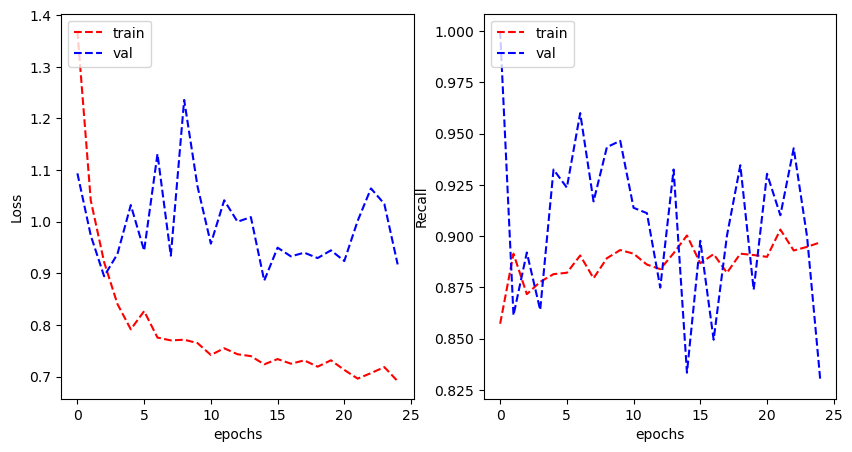

In [43]:
input_shape = (27, 27, 3)
mlp_multi = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])
mlp_multi.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        GlobalPrecision(name='precision'),
        GlobalRecall(name='recall')
    ]
)

history_mlp_multi = mlp_multi.fit(
    multi_train_generator,
    validation_data=multi_validation_generator,
    epochs=25,
    verbose=0
)

plot_learning_curve(
    history_mlp_multi.history['loss'],
    history_mlp_multi.history['val_loss'],
    history_mlp_multi.history['precision'],
    history_mlp_multi.history['val_precision'],
    metric_name='Precision'
)

plot_learning_curve(
    history_mlp_multi.history['loss'],
    history_mlp_multi.history['val_loss'],
    history_mlp_multi.history['recall'],
    history_mlp_multi.history['val_recall'],
    metric_name='Recall'
)

- The CNN model for the cellType (multiclass) uses three convolutional blocks (Conv2D + MaxPooling) with ReLU activations to extract spatial features from images, followed by a Flatten layer, a Dense layer, and a Dropout (0.5) layer to prevent overfitting. The final Dense layer uses softmax activation to output a probability distribution across all cellType classes.
- The MLP model flattens the input image into a 1D vector and processes it through two fully connected Dense layers (256 and 128 units) with ReLU activations, followed by Dropout (0.5) and a softmax output layer. Unlike CNN, the MLP does not capture spatial structure but serves as a baseline for comparison of the models performance. 
- Both models are compiled with the Adam optimizer and use categorical crossentropy loss, which is appropriate for multiclass classification. Global precision and recall are used as metrics to evaluate performance across all classes fairly, especially in imbalanced datasets.

#### Selected Baseline Models
After running the baseline models the **CNN** models were chosen for both classes **isCancerous** and **cellType** to be further optimised and run for the final models for the following reasons.

- Preserves spatial structure: CNNs maintain the 2D structure of images, allowing the model to learn local features such as textures and patterns — something MLPs cannot do, as they flatten the image input.
- Fewer parameters and better generalization: CNNs use shared weights and local connections, reducing the total number of parameters and improving generalization. MLPs require many more parameters for image tasks, increasing the risk of overfitting.
- Stronger validation performance: Empirically, CNNs outperformed MLPs on both tasks in terms of validation accuracy, precision, and recall, particularly in detecting subtle differences between similar cell types and distinguishing cancerous from non-cancerous cells.

### Classification report for Baselines Models CNN

In [47]:


# Reset generator
binary_validation_generator.reset()

# Get predictions
y_prob_bin = cnn_baseline.predict(binary_validation_generator)
y_pred_bin = (y_prob_bin > 0.5).astype(int).ravel()

# Get true labels
y_true_bin = binary_validation_generator.classes
labels_bin = list(binary_validation_generator.class_indices.keys())

# Print classification report
print("\nBinary Classification Report (Baseline CNN):")
print(classification_report(y_true_bin, y_pred_bin, target_names=labels_bin))




# Reset generator
multi_validation_generator.reset()

# Get predictions
y_prob_multi = celltype_model.predict(multi_validation_generator)
y_pred_multi = np.argmax(y_prob_multi, axis=1)

# Get true labels
y_true_multi = multi_validation_generator.classes
labels_multi = list(multi_validation_generator.class_indices.keys())

# Print classification report
print("\nMulticlass Classification Report (Baseline CNN):")
print(classification_report(y_true_multi, y_pred_multi, target_names=labels_multi))



72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

Binary Classification Report (Baseline CNN):
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1114
           1       0.86      0.78      0.82      1169

    accuracy                           0.82      2283
   macro avg       0.82      0.82      0.82      2283
weighted avg       0.82      0.82      0.82      2283

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Multiclass Classification Report (Baseline CNN):
              precision    recall  f1-score   support

           0       0.54      0.45      0.49       357
           1       0.54      0.63      0.58       323
           2       0.82      0.86      0.84      1169
           3       0.51      0.45      0.48       434

    accuracy                           0.68      2283
   macro avg       0.60      0.60      0.60      2283
weighted avg       0.67      0.68      0.68      2283



### Handling Class Imbalance 

In [49]:


# 1) Compute class weights for binary task (isCancerous)
y_bin = train_data['isCancerous'].astype(int).values
weights_bin = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_bin),
    y=y_bin
)
class_weights_binary = {i: w for i, w in enumerate(weights_bin)}

# 2) Compute class weights for multiclass task (cellType)
y_multi = train_data['cellType'].values
classes_multi = np.unique(y_multi)
weights_multi = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes_multi,
    y=y_multi
)
class_weights_multi = {cls: w for cls, w in zip(classes_multi, weights_multi)}

# 3) Oversample binary labels (isCancerous)
counts = train_data['isCancerous'].value_counts()
max_count = counts.max()
oversampled_dfs = []
for cls, cnt in counts.items():
    if cnt < max_count:
        df_cls = train_data[train_data['isCancerous'] == cls]
        oversampled_dfs.append(df_cls.sample(max_count - cnt, 
                                             replace=True, 
                                             random_state=42))
train_balanced = pd.concat([train_data] + oversampled_dfs).reset_index(drop=True)

# 4) Binary Augmented Generator
binary_aug_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.1
).flow_from_dataframe(
    train_balanced,
    directory=img_dir,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# 5) Oversample multiclass (cellType)
counts_multi = train_data['cellType'].value_counts()
max_ct_multi = counts_multi.max()
oversampled_multi = []
for cls, cnt in counts_multi.items():
    if cnt < max_ct_multi:
        df_cls = train_data[train_data['cellType'] == cls]
        oversampled_multi.append(df_cls.sample(max_ct_multi - cnt, 
                                               replace=True, 
                                               random_state=42))
train_multi_balanced = pd.concat([train_data] + oversampled_multi).reset_index(drop=True)

# 6) Multiclass Augmented Generator
multi_aug_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.1
).flow_from_dataframe(
    dataframe=train_multi_balanced,
    directory=img_dir,
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# 7) EarlyStopping Callbacks
early_stop_bin = EarlyStopping(
    monitor='accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)

early_stop_multi = EarlyStopping(
    monitor='accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)


Found 7578 validated image filenames belonging to 2 classes.
Found 7940 validated image filenames belonging to 4 classes.


- **Class Weights** computes inverse‐frequency weights so the loss penalizes mistakes on rare classes more heavily; this keeps the model from simply predicting the majority label to minimize loss. It’s lightweight, but ensures the optimizer sees minority classes as equally important.
- **Oversampling** replicates under-represented samples until each class has the same count, giving the model equal exposure to all categories. While it can risk over-fitting to duplicates, when paired with augmentation it effectively counteracts extreme imbalance.
- **Data Augmentation** applies random rescaling, flips, rotations, and zooms at training time to create new variants of each image, boosting dataset size and diversity without new data collection. This forces the network to learn transformation-invariant features, improving real-world robustness.
- **Early Stopping** tracks validation accuracy and halt training once it hasn’t improved for a set number of epochs, preventing the model from memorizing noise. Restoring the best weights guarantees you deploy the version with the highest true generalization performance.

In [51]:
# Checks
# Binary task
print("Binary class counts after oversampling:")
print(train_balanced['isCancerous'].value_counts())

# Multiclass task
print("\nMulticlass class counts after oversampling:")
print(train_multi_balanced['cellType'].value_counts())


Binary class counts after oversampling:
isCancerous
0    3789
1    3789
Name: count, dtype: int64

Multiclass class counts after oversampling:
cellType
0    1985
1    1985
3    1985
2    1985
Name: count, dtype: int64


### Sample Images after Augmentation and Oversampling 

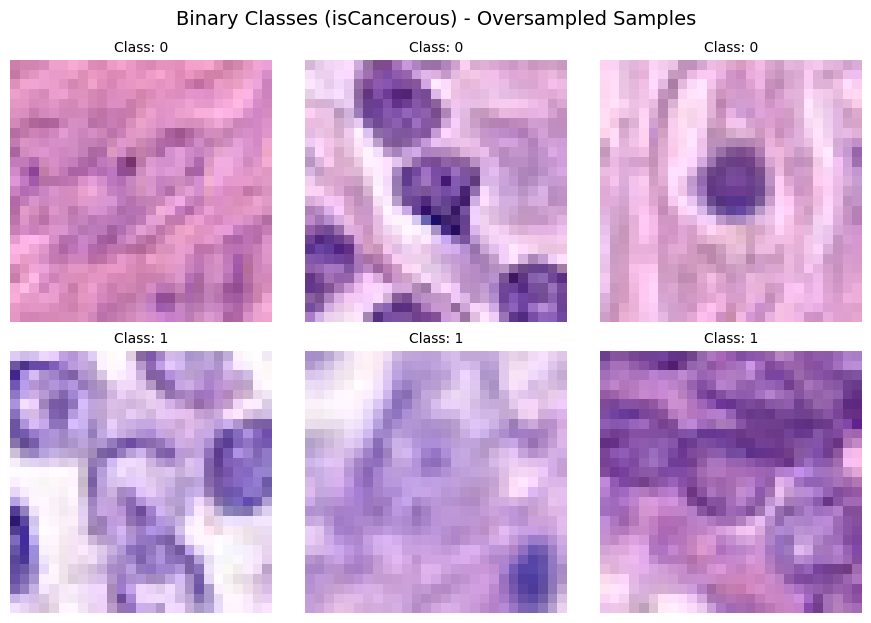

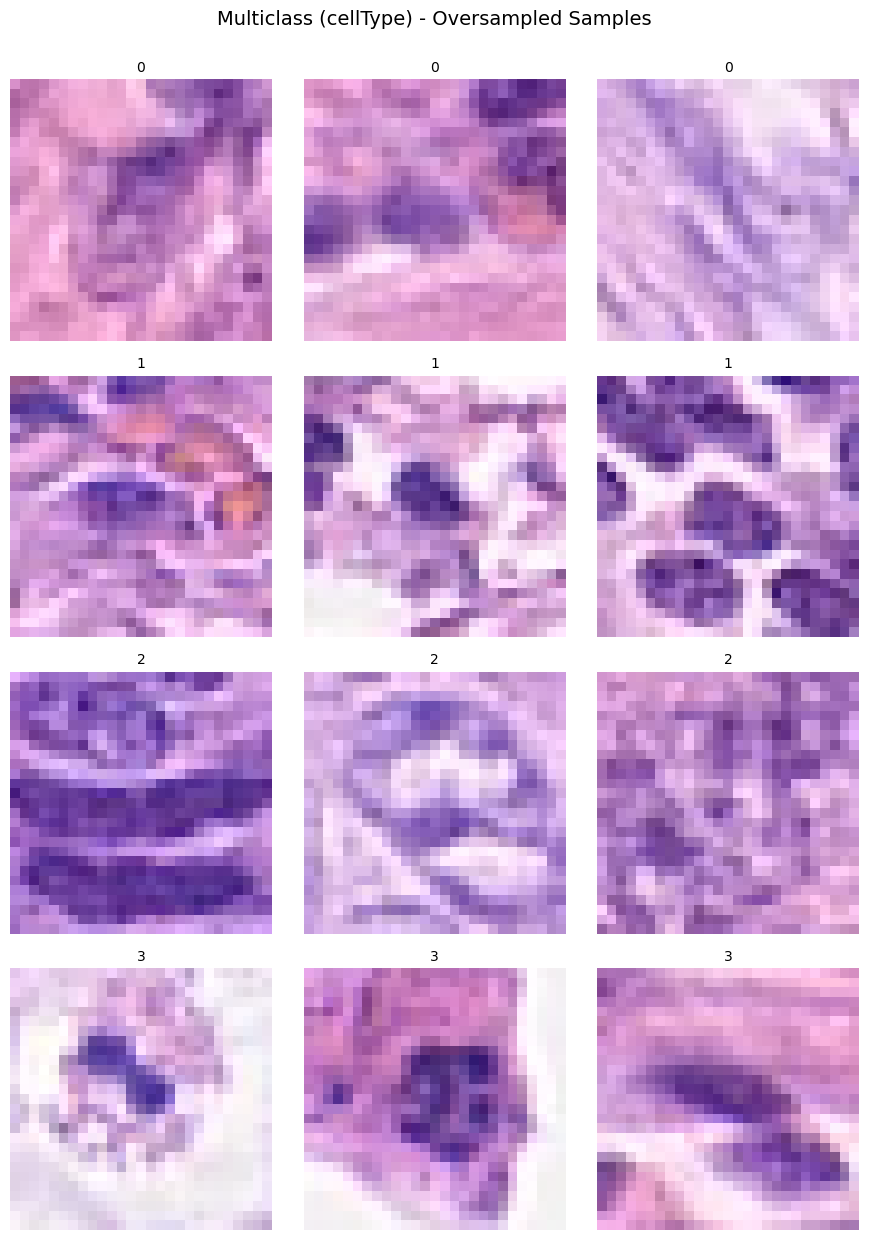

In [53]:

#binary 
# Ensure string labels for plotting
train_balanced['isCancerous'] = train_balanced['isCancerous'].astype(str)

samples_per_class = 3
binary_classes = sorted(train_balanced['isCancerous'].unique())
n_rows = len(binary_classes)
n_cols = samples_per_class

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

if n_rows == 1:
    axes = [axes]

for i, cls in enumerate(binary_classes):
    samples = train_balanced[train_balanced['isCancerous'] == cls].sample(n=samples_per_class, random_state=42)
    for j, img_name in enumerate(samples['ImageName']):
        img_path = os.path.join(img_dir, img_name)
        img = mpimg.imread(img_path)
        ax = axes[i][j] if n_rows > 1 else axes[j]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Class: {cls}", fontsize=10)

plt.tight_layout()
plt.suptitle("Binary Classes (isCancerous) - Oversampled Samples", fontsize=14, y=1.03)
plt.show()




#Multiclass
# Ensure string labels for plotting
train_multi_balanced['cellType'] = train_multi_balanced['cellType'].astype(str)

samples_per_class = 3
cell_types = sorted(train_multi_balanced['cellType'].unique())
n_rows = len(cell_types)
n_cols = samples_per_class

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

if n_rows == 1:
    axes = [axes]

for i, cell_type in enumerate(cell_types):
    samples = train_multi_balanced[train_multi_balanced['cellType'] == cell_type].sample(n=samples_per_class, random_state=42)
    for j, img_name in enumerate(samples['ImageName']):
        img_path = os.path.join(img_dir, img_name)
        img = mpimg.imread(img_path)
        ax = axes[i][j] if n_rows > 1 else axes[j]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{cell_type}", fontsize=10)

plt.tight_layout()
plt.suptitle("Multiclass (cellType) - Oversampled Samples", fontsize=14, y=1.03)
plt.show()



### Algorithm Configuration
- L2 regularization was applied to convolutional and dense layers to penalize large weight values during training.
- L2 was chosen to reduce overfitting by encouraging the model to distribute importance across many features, which is ideal for image data where most pixels contribute to meaningful patterns.

## 1.4 Model Optimization
### Overfitting/Underfitting Detection

C:\Users\azhar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\azhar\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `accuracy` which is not available. Available metrics are: loss,precision,recall,val_loss,val_precision,val_recall
  current = self.get_monitor_value(logs)


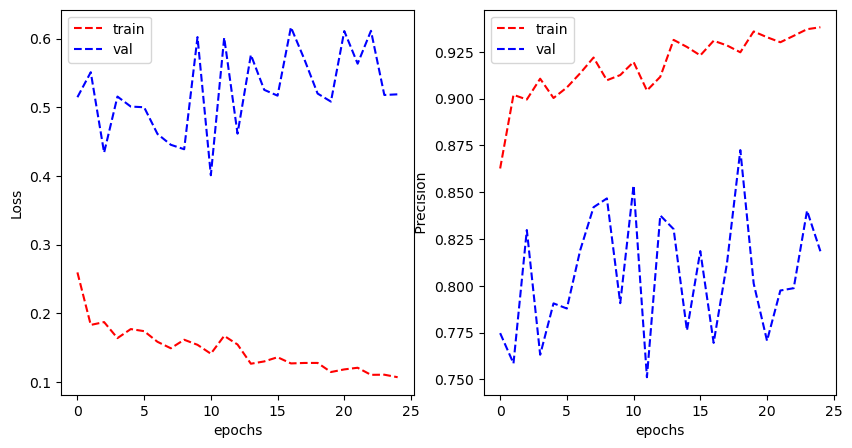

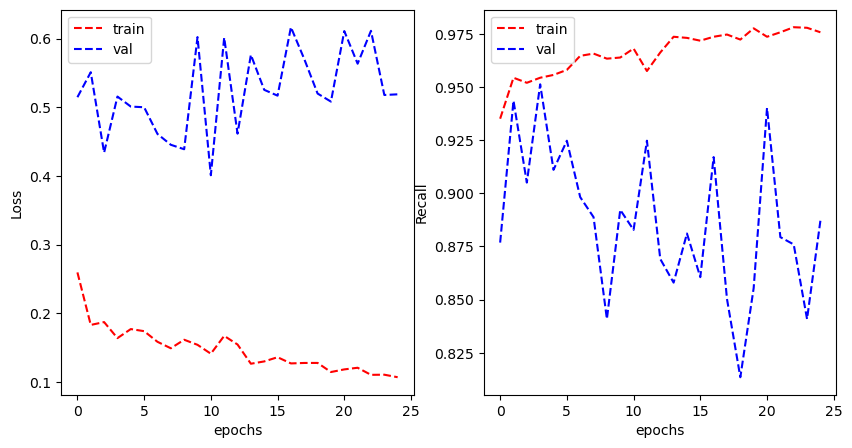

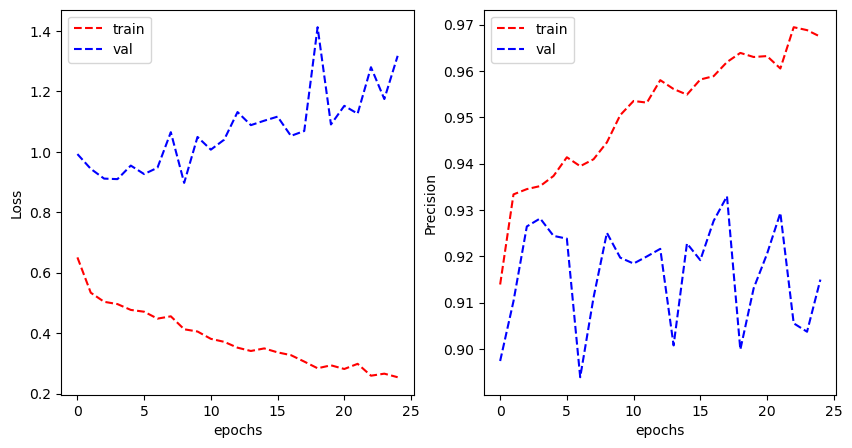

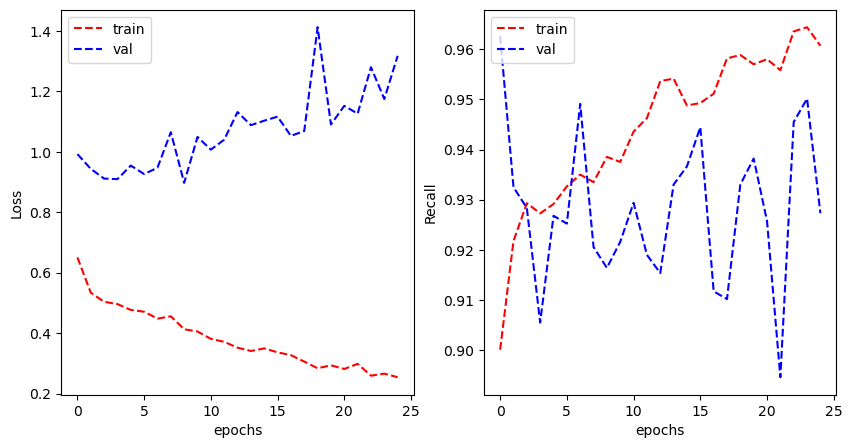

In [56]:
# 2) Balanced binary CNN with fit_generator
history_cnn_balanced = cnn_baseline.fit(
    binary_aug_generator,
    validation_data=binary_validation_generator,
    epochs=25,
    class_weight=class_weights_binary,
    callbacks=[early_stop_bin],
    verbose=0
)

# Plot using precision
plot_learning_curve(
    history_cnn_balanced.history['loss'],
    history_cnn_balanced.history['val_loss'],
    history_cnn_balanced.history['precision'],
    history_cnn_balanced.history['val_precision'],
    metric_name=' Precision '
)

plot_learning_curve(
    history_cnn_balanced.history['loss'],
    history_cnn_balanced.history['val_loss'],
    history_cnn_balanced.history['recall'],
    history_cnn_balanced.history['val_recall'],
    metric_name='Recall'
)

# 3) Balanced multiclass CNN with fit_generator
history_cnn_multi_balanced = celltype_model.fit(
    multi_aug_generator,
    validation_data=multi_validation_generator,
    epochs=25,
    class_weight=class_weights_multi,
    callbacks=[early_stop_multi],
    verbose=0
)

# Plot using precision
plot_learning_curve(
    history_cnn_multi_balanced.history['loss'],
    history_cnn_multi_balanced.history['val_loss'],
    history_cnn_multi_balanced.history['precision'],
    history_cnn_multi_balanced.history['val_precision'],
    metric_name='Precision'
)

plot_learning_curve(
    history_cnn_multi_balanced.history['loss'],
    history_cnn_multi_balanced.history['val_loss'],
    history_cnn_multi_balanced.history['recall'],
    history_cnn_multi_balanced.history['val_recall'],
    metric_name='Recall'
)


- For both the precision graphs for the multiclass and binary there is overfitting as observed by the training precision (red line) increasing steadily, but the validation (blue line) is fluctuating and not improving. Therefore, suggesting overfitting to the training data.
- The previous point is also dictated by the loss against epochs graph, showing the steadily decreasing loss in the training data, however a higher loss for validation with greater fluctuations.
- It can be oberserved that for the multi class recall graph, there is intially a higher level of recall for the validation data which ends up decreasing over every epoch, while the training data increases eventually being higher than the validation on the last epochs.

### Optimization Techniques

C:\Users\azhar\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\azhar\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `accuracy` which is not available. Available metrics are: loss,precision,recall,val_loss,val_precision,val_recall
  current = self.get_monitor_value(logs)


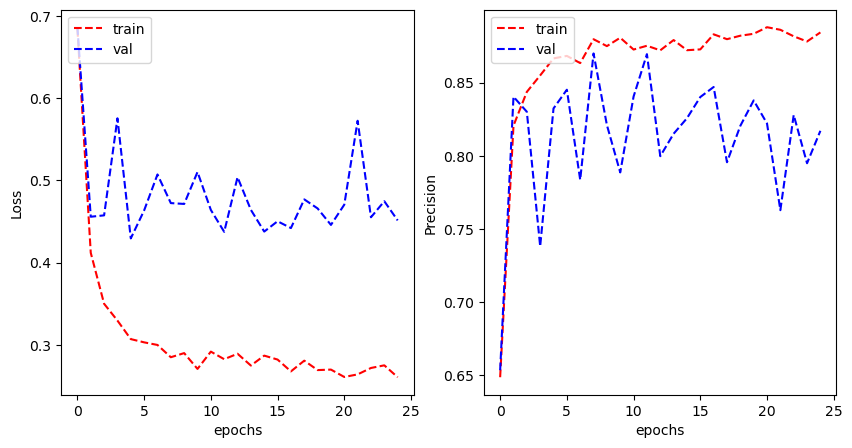

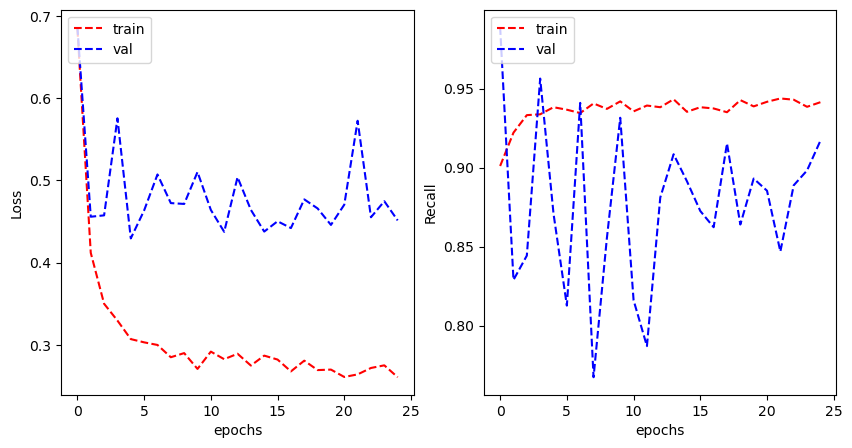

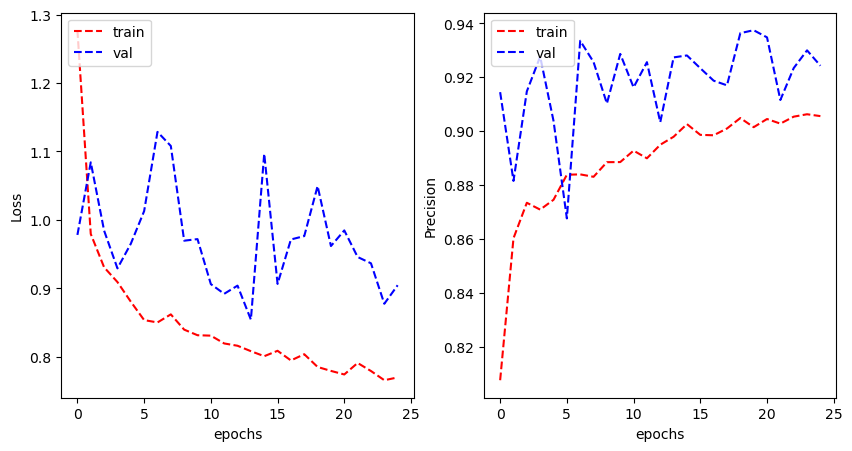

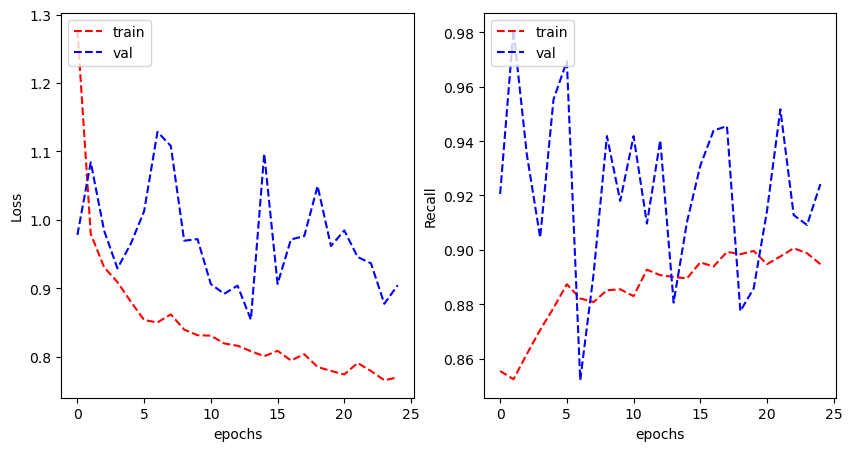

In [59]:


# Hyperparameters
reg_lambda     = 0.001     # L2 strength
drop_rate_conv = 0.25      # Dropout after conv blocks
drop_rate_dense= 0.5       # Dropout before final dense

# Binary CNN with L2 + Dropout
cnn_baseline = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu',
        kernel_regularizer=regularizers.l2(reg_lambda),
        input_shape=(27, 27, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    Dropout(drop_rate_conv),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu',
        kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2,2)),
    Dropout(drop_rate_conv),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu',
        kernel_regularizer=regularizers.l2(reg_lambda)),
    Dropout(drop_rate_dense),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_baseline.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

# Multiclass CNN with L2 + Dropout
celltype_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu',
        kernel_regularizer=regularizers.l2(reg_lambda),
        input_shape=(27, 27, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    Dropout(drop_rate_conv),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu',
        kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2,2)),
    Dropout(drop_rate_conv),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu',
        kernel_regularizer=regularizers.l2(reg_lambda)),
    Dropout(drop_rate_dense),

    tf.keras.layers.Dense(num_classes, activation='softmax')
])

celltype_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        GlobalPrecision(name='precision'),
        GlobalRecall(name='recall')
    ]
)

# ─── Train & Plot for Binary CNN with L2 + Dropout ───
history_cnn_l2 = cnn_baseline.fit(
    binary_aug_generator,
    validation_data=binary_validation_generator,
    epochs=25,
    class_weight=class_weights_binary,
    callbacks=[early_stop_bin],
    verbose=0
)

plot_learning_curve(
    history_cnn_l2.history['loss'],
    history_cnn_l2.history['val_loss'],
    history_cnn_l2.history['precision'],
    history_cnn_l2.history['val_precision'],
    metric_name='Precision'
)
plot_learning_curve(
    history_cnn_l2.history['loss'],
    history_cnn_l2.history['val_loss'],
    history_cnn_l2.history['recall'],
    history_cnn_l2.history['val_recall'],
    metric_name='Recall'
)

# ─── Train & Plot for Multiclass CNN with L2 + Dropout ───
history_multi_l2 = celltype_model.fit(
    multi_aug_generator,
    validation_data=multi_validation_generator,
    epochs=25,
    class_weight=class_weights_multi,
    callbacks=[early_stop_multi],
    verbose=0
)


# Plot using precision


plot_learning_curve(
    history_multi_l2.history['loss'],
    history_multi_l2.history['val_loss'],
    history_multi_l2.history['precision'],
    history_multi_l2.history['val_precision'],
    metric_name='Precision'
)
plot_learning_curve(
    history_multi_l2.history['loss'],
    history_multi_l2.history['val_loss'],
    history_multi_l2.history['recall'],
    history_multi_l2.history['val_recall'],
    metric_name='Recall'
)


L2 and dropout regularization were made use to improve the models generalization to address the overfitting faced by the baseline models.

**L2 Regularization**
Applied using kernel_regularizer=regularizers.l2(reg_lambda) in each convolutional and dense layer for both models.
- Adds a penalty to the loss function based on the magnitude of the weights, helping prevent overfitting by discouraging large weights.
- Encourages the model to learn smoother, more generalizable patterns across the image rather than memorizing the training data.

**Dropout Regularization**
Implemented after each convolutional block and before the final dense layer using Dropout(drop_rate_conv) and Dropout(drop_rate_dense).
- Randomly turns off a fraction of neurons during training to prevent the model from relying too heavily on specific activations.
- Improves generalization and robustness, especially when working with duplicated (oversampled) or augmented data.

C:\Users\azhar\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `accuracy` which is not available. Available metrics are: loss,precision,recall,val_loss,val_precision,val_recall
  current = self.get_monitor_value(logs)


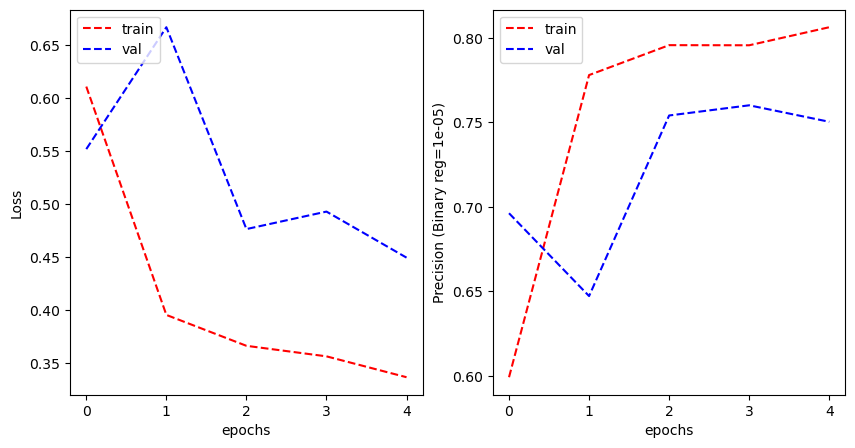

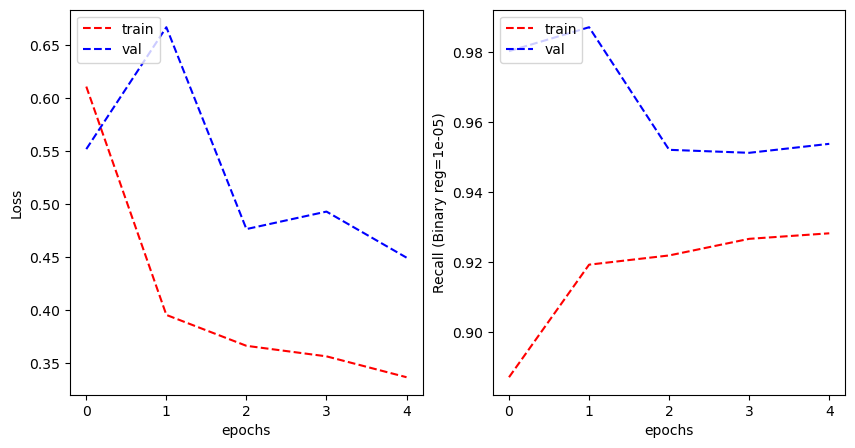

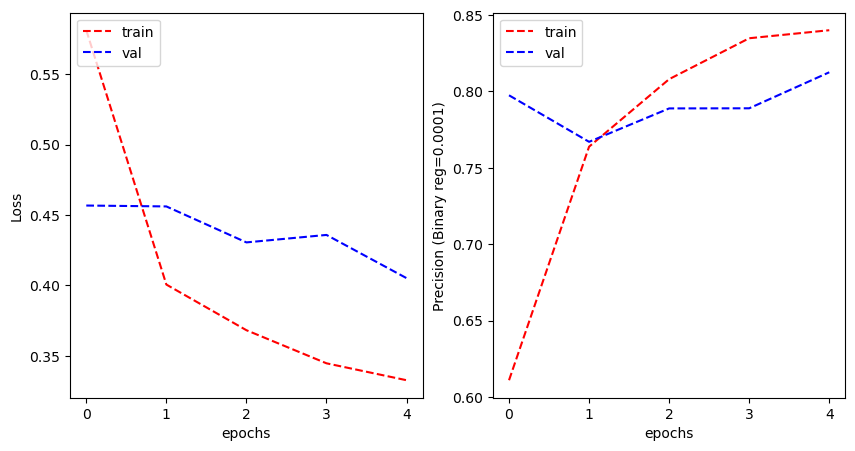

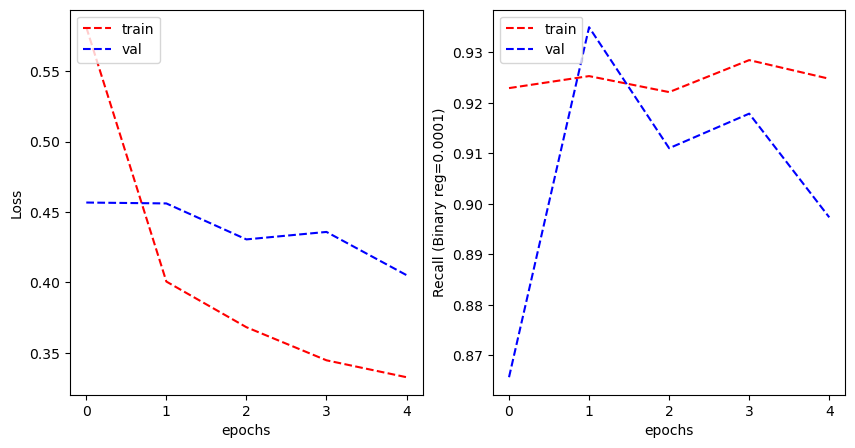

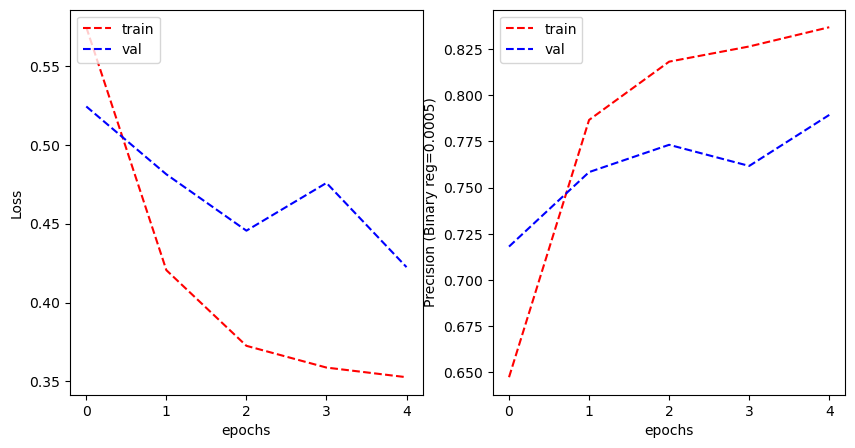

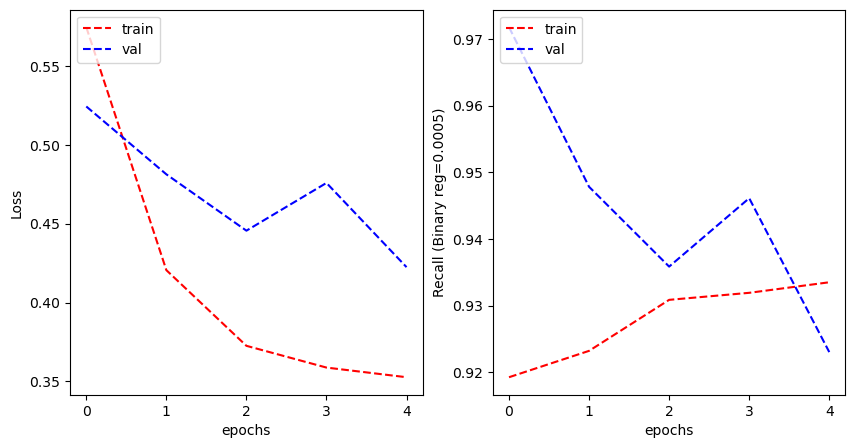

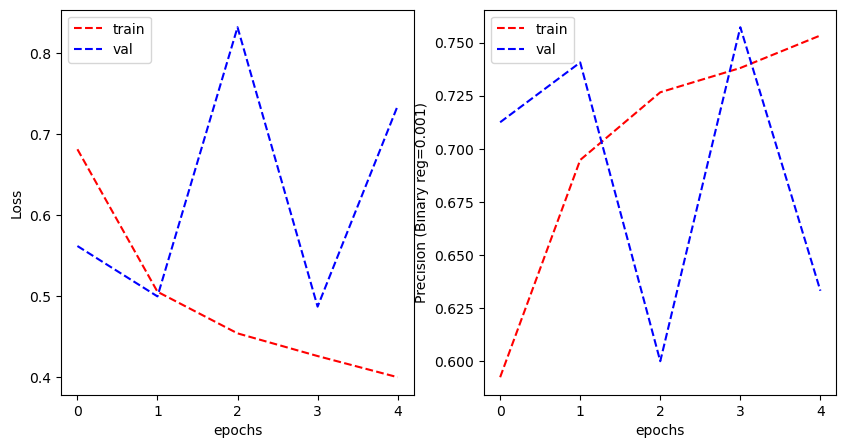

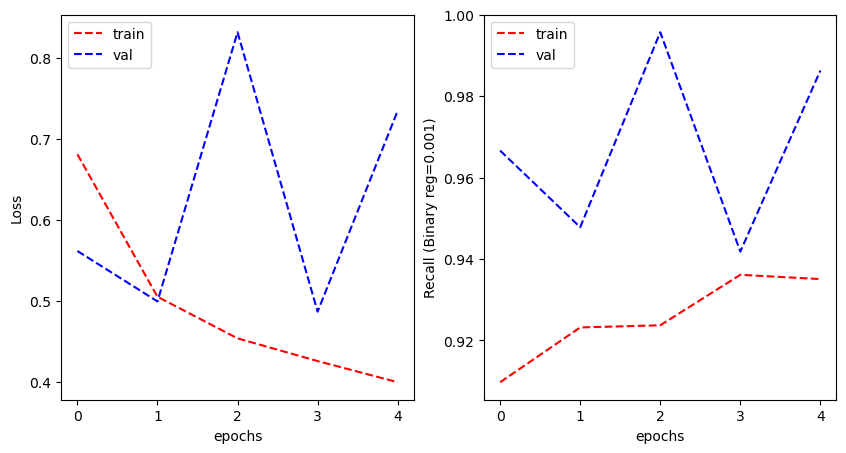

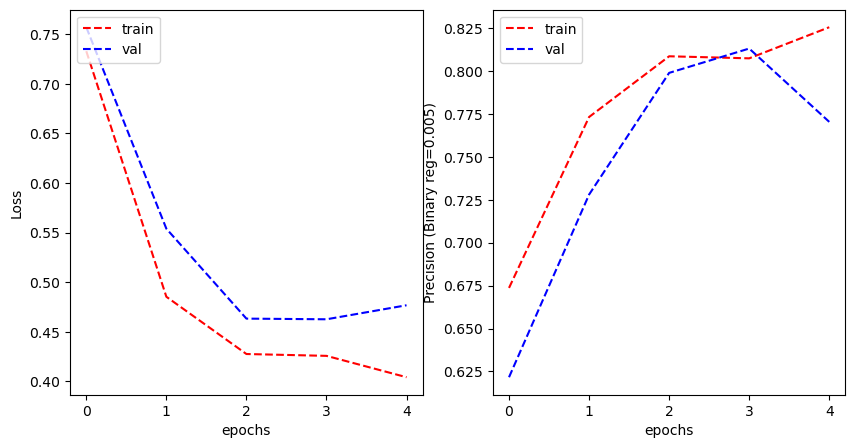

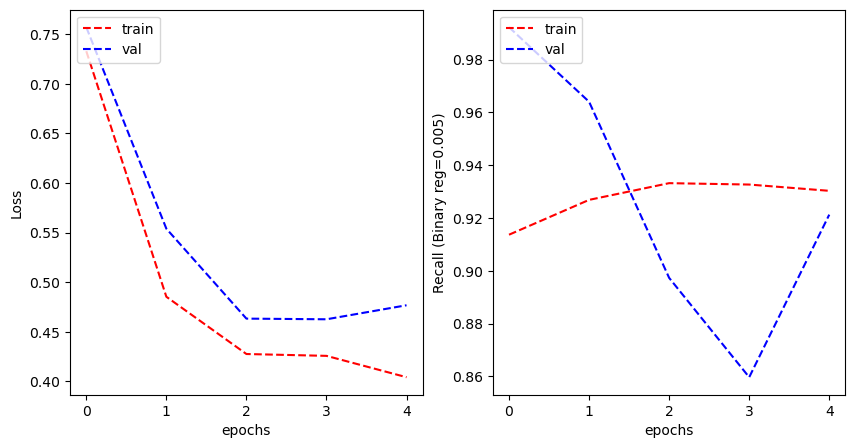

Best Binary reg_lambda: 0.005 → val_precision: 0.8131067752838135


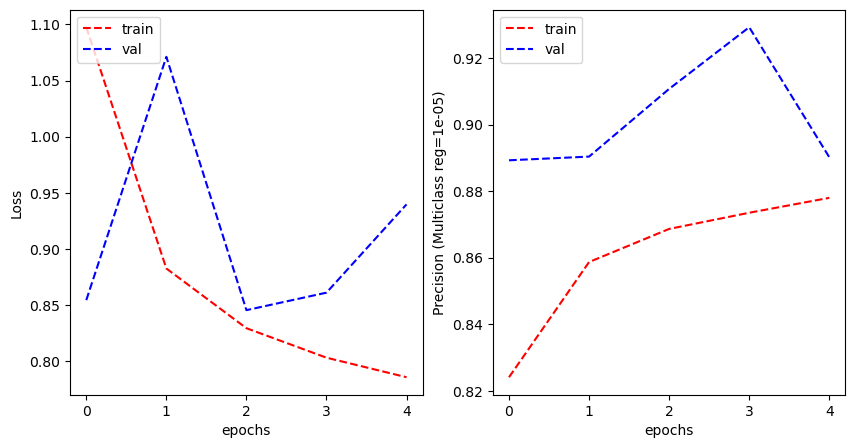

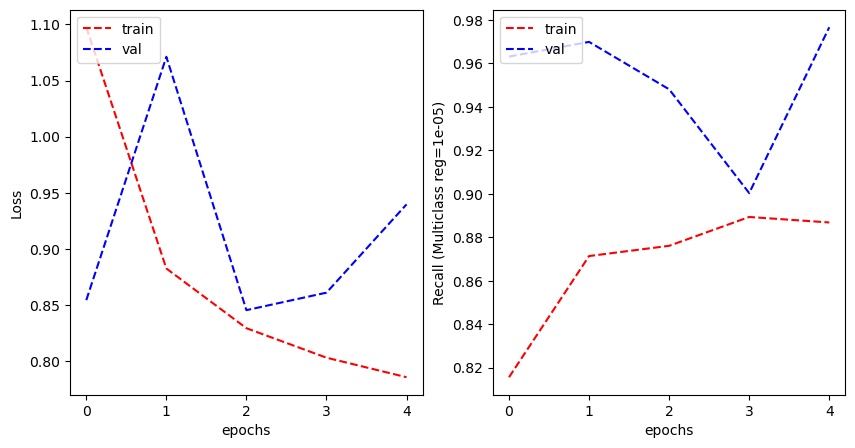

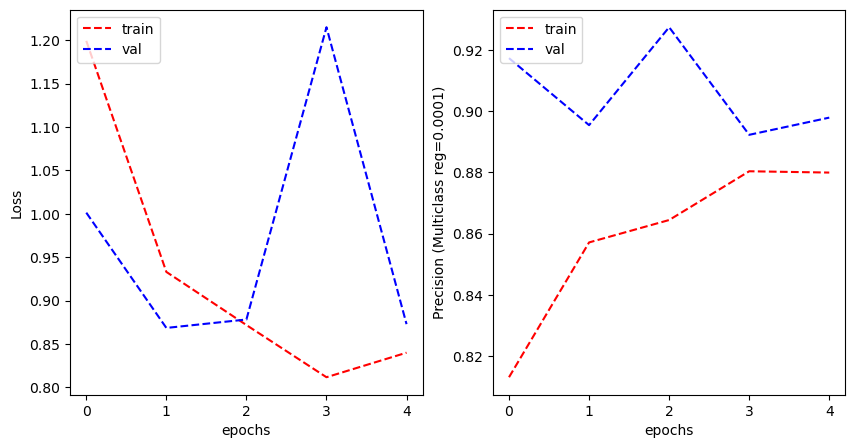

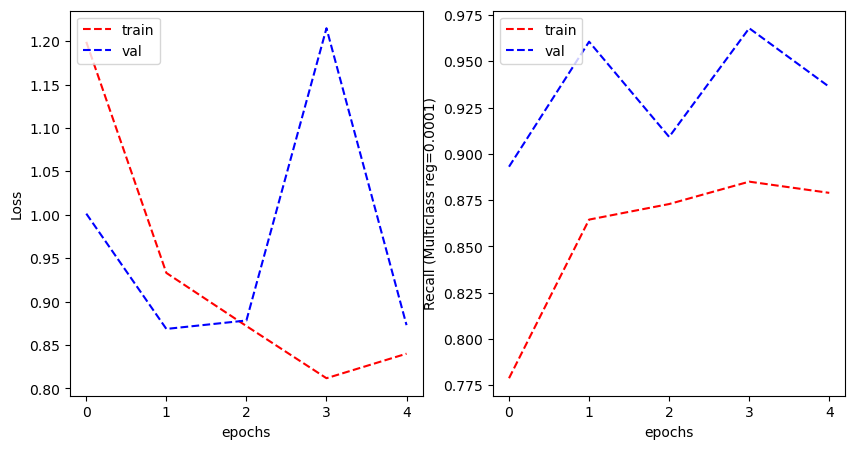

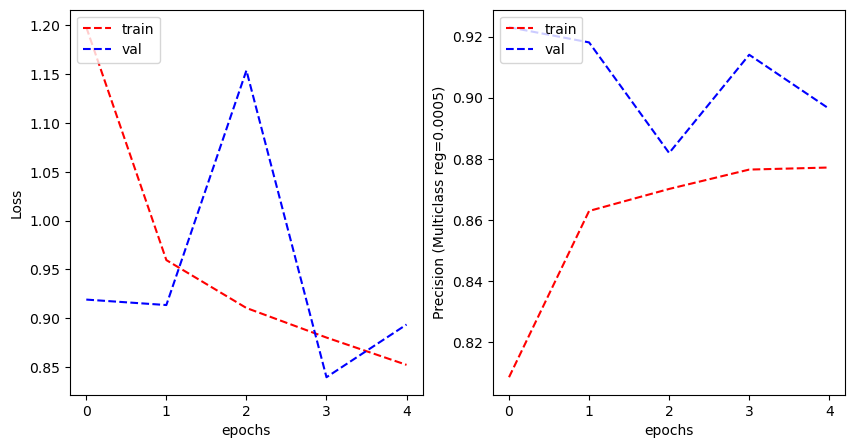

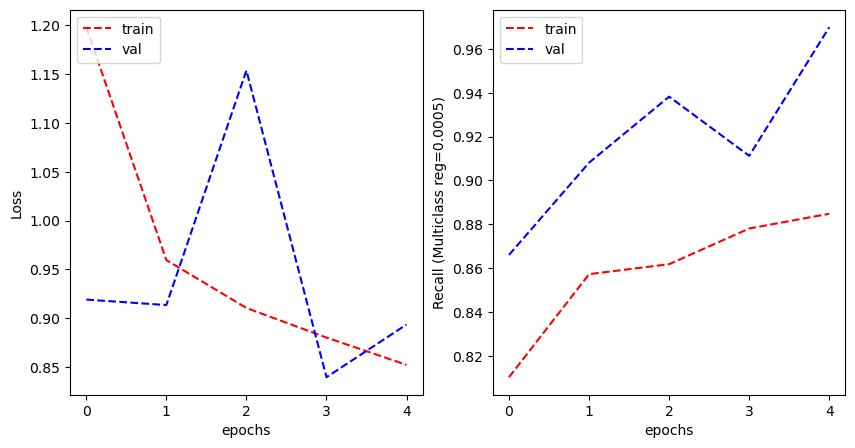

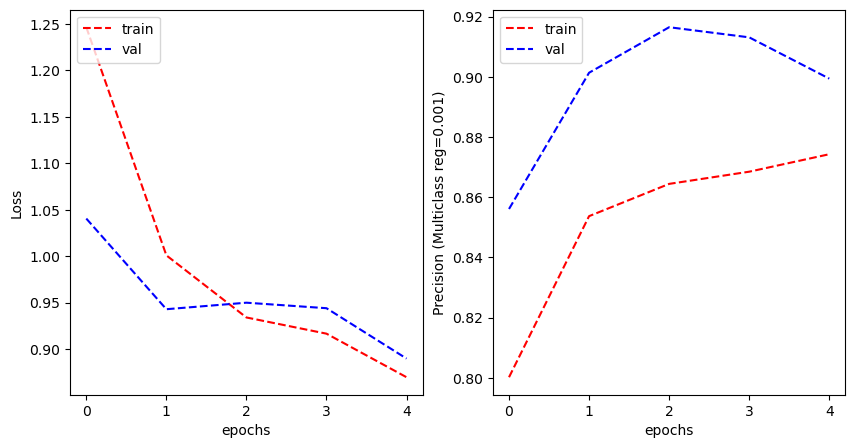

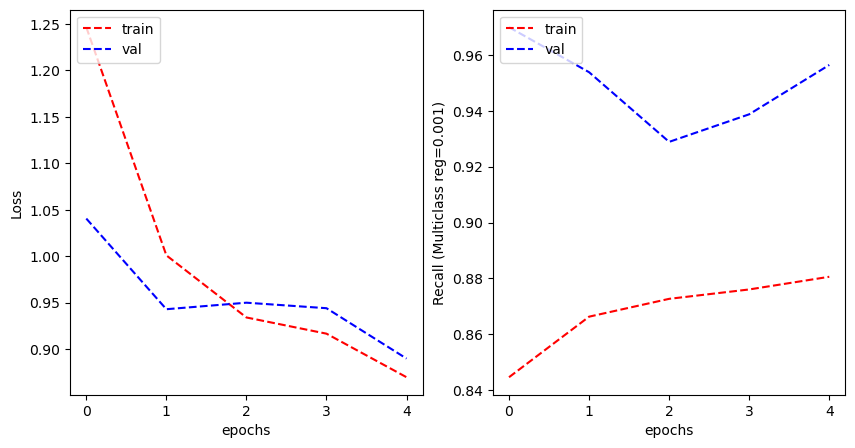

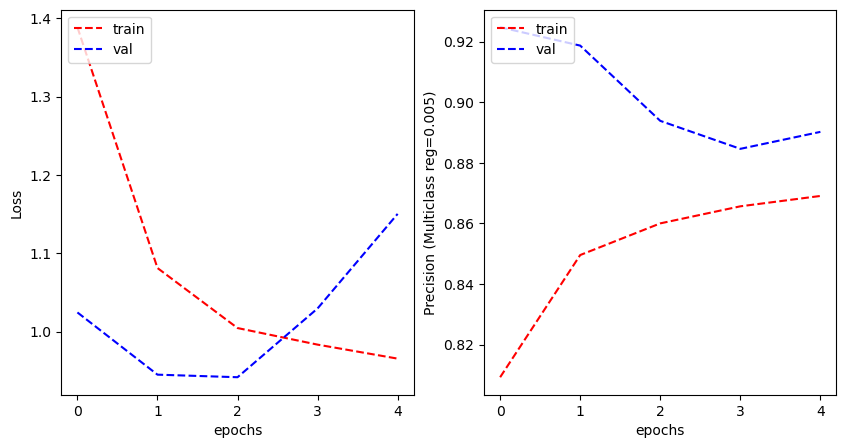

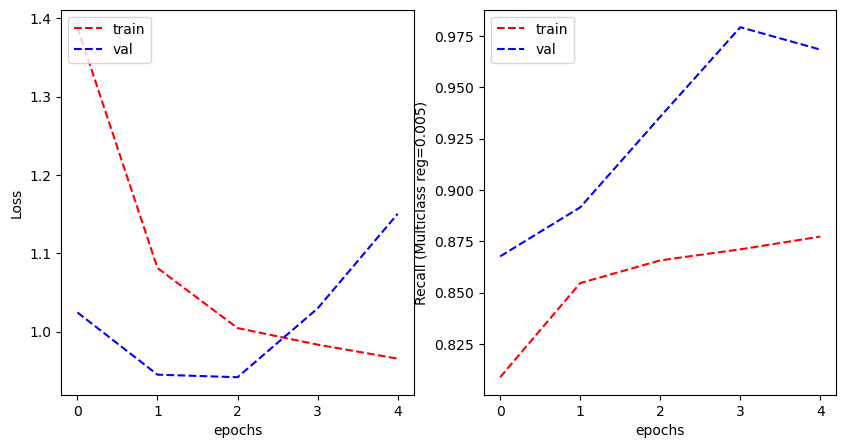

Best Multi reg_lambda: 1e-05 → val_precision: 0.9292604327201843


In [61]:



# Helper functions to build models with given hyperparameters
def create_binary_cnn(reg_lambda, drop_conv, drop_dense):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(27, 27, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),
   #     tf.keras.layers.Dropout(drop_conv),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Dropout(drop_dense),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    return model

def create_multi_cnn(reg_lambda, drop_conv, drop_dense, num_classes):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(27, 27, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),
    #    tf.keras.layers.Dropout(drop_conv),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Dropout(drop_dense),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=[
            GlobalPrecision(name='precision'),
            GlobalRecall(name='recall')
        ]
    )
    return model

# ── Hyperparameter list ──
reg_list = [1e-5, 1e-4, 5e-4, 1e-3, 5e-3]

# ── Tune binary reg_lambda ──
best_bin_prec = 0.0
best_bin_lambda = None

for reg in reg_list:
    model = create_binary_cnn(reg, 0.1, 0.7)
    history = model.fit(
        binary_aug_generator,
        validation_data=binary_validation_generator,
        epochs=5,
        class_weight=class_weights_binary,
        callbacks=[early_stop_bin],
        verbose=0
    )
    val_prec = max(history.history['val_precision'])
    if val_prec > best_bin_prec:
        best_bin_prec = val_prec
        best_bin_lambda = reg

    # Plot for each run
    plot_learning_curve(
        history.history['loss'],
        history.history['val_loss'],
        history.history['precision'],
        history.history['val_precision'],
        metric_name=f'Precision (Binary reg={reg})'
    )

    plot_learning_curve(
        history.history['loss'],
        history.history['val_loss'],
        history.history['recall'],
        history.history['val_recall'],
        metric_name=f'Recall (Binary reg={reg})'
    )

print("Best Binary reg_lambda:", best_bin_lambda, "→ val_precision:", best_bin_prec)

# ── Tune multiclass reg_lambda ──
num_classes = train_data['cellType'].nunique()
best_multi_prec = 0.0
best_multi_lambda = None

for reg in reg_list:
    model = create_multi_cnn(reg, 0.4, 0.3, num_classes)
    history = model.fit(
        multi_aug_generator,
        validation_data=multi_validation_generator,
        epochs=5,
        class_weight=class_weights_multi,
        callbacks=[early_stop_multi],
        verbose=0
    )
    val_prec = max(history.history['val_precision'])
    if val_prec > best_multi_prec:
        best_multi_prec = val_prec
        best_multi_lambda = reg

    # Plot for each run
    plot_learning_curve(
        history.history['loss'],
        history.history['val_loss'],
        history.history['precision'],
        history.history['val_precision'],
        metric_name=f'Precision (Multiclass reg={reg})'
    )

    plot_learning_curve(
        history.history['loss'],
        history.history['val_loss'],
        history.history['recall'],
        history.history['val_recall'],
        metric_name=f'Recall (Multiclass reg={reg})'
    )

print("Best Multi reg_lambda:", best_multi_lambda, "→ val_precision:", best_multi_prec)


- The validation set was used to evaluate the model’s performance on unseen data during training. It helps detect overfitting and guides decisions such as when to stop training (via early stopping) and which model configuration performs best. Unlike the test set, the validation set is used during model development to fine-tune hyperparameter.
- Selecting L2 lamba/alpha value to be tuned as the hyperparameter. The best L2 value was found through listing various regularisation strengths and then ran the models for 5 epochs, the best lambda was recorded for every run and if the validation precision score was higher then the previous run it was then replaced, finally resulting in the best lambda value.


### Final Model Accuracy (With Validation Data)
#### isCancerous and CellType

Epoch 1/27
237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 1.0391 - precision: 0.5662 - recall: 0.8950 - val_loss: 0.7082 - val_precision: 0.6092 - val_recall: 0.9923
Epoch 2/27
  3/237 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.5321 - precision: 0.7248 - recall: 0.9691 

C:\Users\azhar\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `accuracy` which is not available. Available metrics are: loss,precision,recall,val_loss,val_precision,val_recall
  current = self.get_monitor_value(logs)


237/237 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.5469 - precision: 0.7169 - recall: 0.9103 - val_loss: 0.5086 - val_precision: 0.7912 - val_recall: 0.9042
Epoch 3/27
237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.4899 - precision: 0.7606 - recall: 0.9132 - val_loss: 0.5105 - val_precision: 0.7840 - val_recall: 0.9222
Epoch 4/27
237/237 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.4348 - precision: 0.7917 - recall: 0.9241 - val_loss: 0.5586 - val_precision: 0.7289 - val_recall: 0.9589
Epoch 5/27
237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.4401 - precision: 0.7943 - recall: 0.9218 - val_loss: 0.5457 - val_precision: 0.7415 - val_recall: 0.9521
Epoch 6/27
237/237 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.4245 - precision: 0.8026 - recall: 0.9170 - val_loss: 0.4862 - val_precision: 0.7854 - val_recall: 0.9204
Epoch 7/27
237/237 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.3917 - precision: 0.8277 - recall: 0.9318 - val_loss: 0.4657 - val_precision: 0.7964 - val_recall

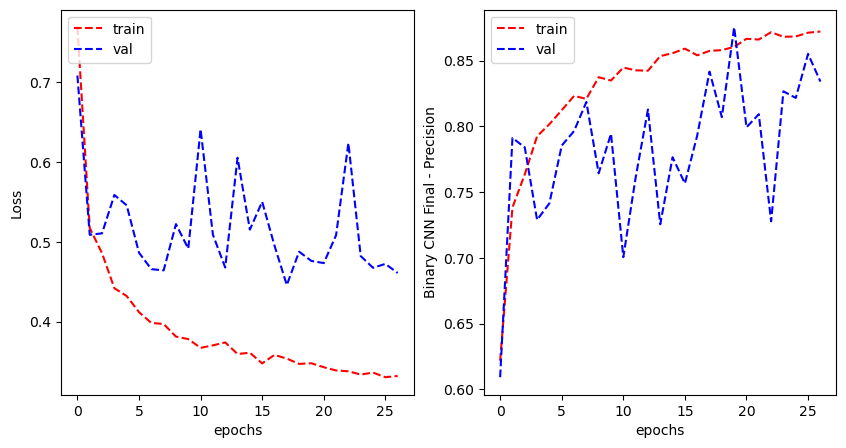

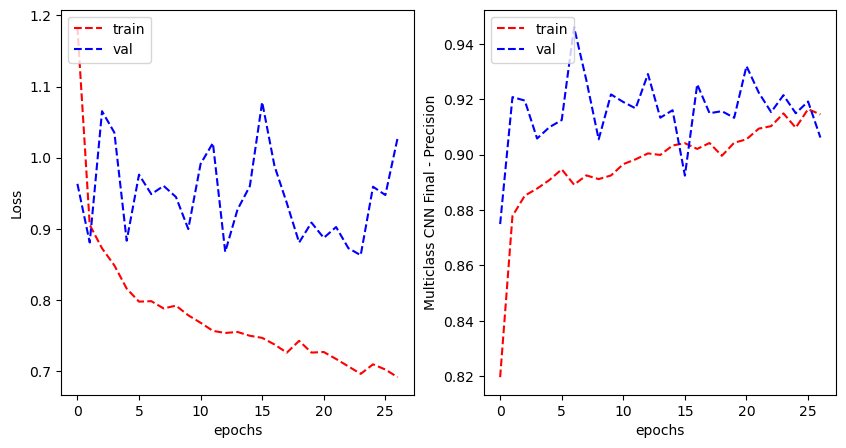

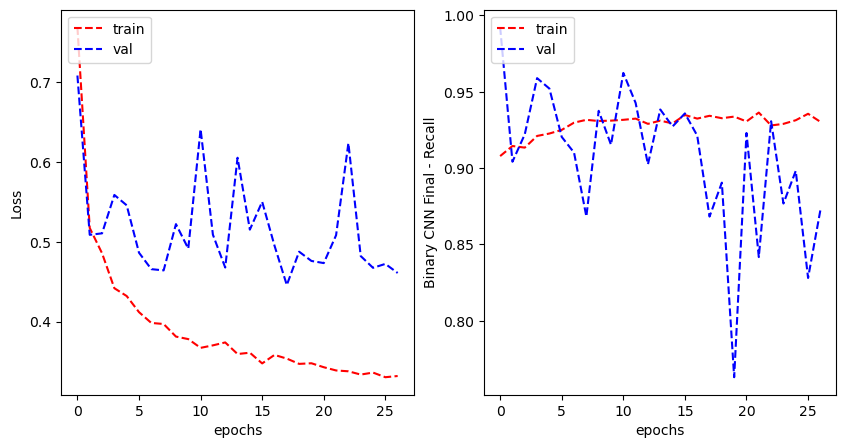

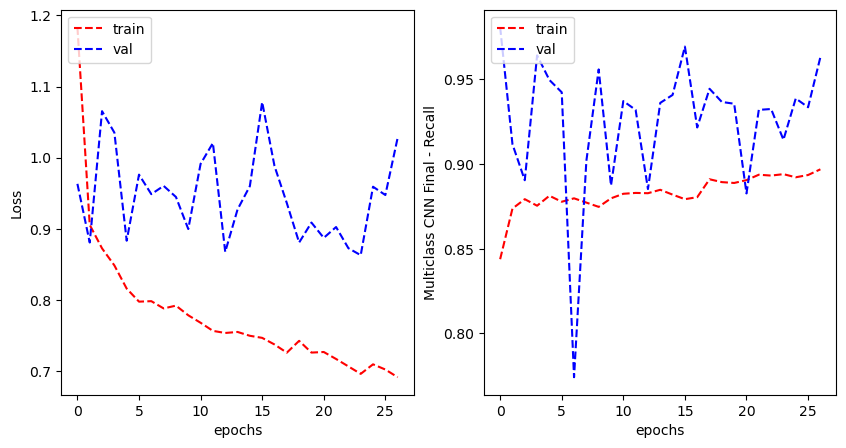

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1114
           1       0.83      0.87      0.85      1169

    accuracy                           0.85      2283
   macro avg       0.85      0.85      0.85      2283
weighted avg       0.85      0.85      0.85      2283

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           0       0.70      0.46      0.56       357
           1       0.34      0.82      0.48       323
           2       0.87      0.74      0.80      1169
           3       0.58      0.36      0.45       434

    accuracy                           0.64      2283
   macro avg       0.62      0.60      0.57      2283
weighted avg       0.71      0.64      0.65      2283



In [64]:
# ── Instantiate final models with your chosen hyperparameters ──
bin_reg, bin_dconv, bin_ddense = 0.005, 0.1, 0.7
final_binary = create_binary_cnn(bin_reg, bin_dconv, bin_ddense)

multi_reg, multi_dconv, multi_ddense = 0.001, 0, 0
num_classes = train_data['cellType'].nunique()
final_multi = create_multi_cnn(multi_reg, multi_dconv, multi_ddense, num_classes)

# ── Train them ──
history_bin = final_binary.fit(
    binary_aug_generator,
    validation_data=binary_validation_generator,
    epochs=27,
    class_weight=class_weights_binary,
    callbacks=[early_stop_bin],
    verbose=1
)

history_multi = final_multi.fit(
    multi_aug_generator,
    validation_data=multi_validation_generator,
    epochs=27,
    class_weight=class_weights_multi,
    callbacks=[early_stop_multi],
    verbose=1
)

# ── Plot learning curves (Precision) ──
plot_learning_curve(
    history_bin.history['loss'],
    history_bin.history['val_loss'],
    history_bin.history['precision'],
    history_bin.history['val_precision'],
    metric_name='Binary CNN Final - Precision'
)

plot_learning_curve(
    history_multi.history['loss'],
    history_multi.history['val_loss'],
    history_multi.history['precision'],
    history_multi.history['val_precision'],
    metric_name='Multiclass CNN Final - Precision'
)

# ── Plot learning curves (Recall) ──
plot_learning_curve(
    history_bin.history['loss'],
    history_bin.history['val_loss'],
    history_bin.history['recall'],
    history_bin.history['val_recall'],
    metric_name='Binary CNN Final - Recall'
)

plot_learning_curve(
    history_multi.history['loss'],
    history_multi.history['val_loss'],
    history_multi.history['recall'],
    history_multi.history['val_recall'],
    metric_name='Multiclass CNN Final - Recall'
)

# Classification reports ──

binary_validation_generator.reset()
y_pred_bin = (final_binary.predict(binary_validation_generator) > 0.5).astype(int).ravel()
y_true_bin = binary_validation_generator.classes
print(classification_report(y_true_bin, y_pred_bin,
      target_names=list(binary_validation_generator.class_indices)))

multi_validation_generator.reset()

y_pred_multi = np.argmax(final_multi.predict(multi_validation_generator), axis=1)
y_true_multi = multi_validation_generator.classes
print(classification_report(y_true_multi, y_pred_multi,
      target_names=list(multi_validation_generator.class_indices)))


### Final Model Accuracy (With Test Data)
#### isCancerous and CellType

 9/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

C:\Users\azhar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Binary Test Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.86       914
           1       0.90      0.78      0.84       925

    accuracy                           0.85      1839
   macro avg       0.85      0.85      0.85      1839
weighted avg       0.85      0.85      0.85      1839



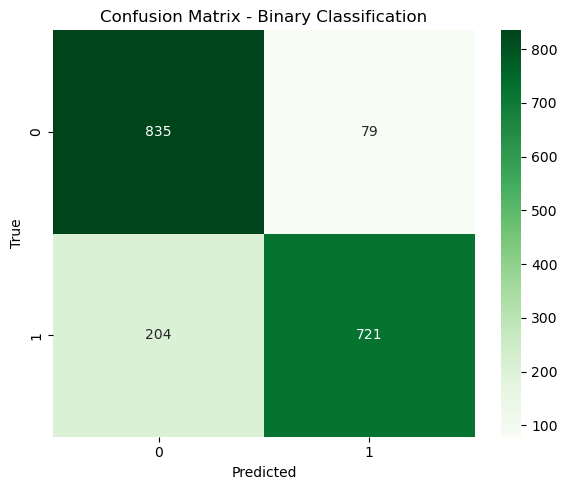

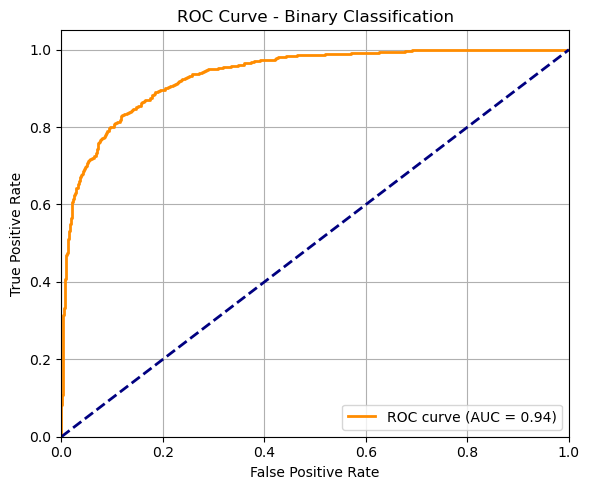

 9/58 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

C:\Users\azhar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Multiclass Test Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.31      0.40       261
           1       0.44      0.83      0.58       432
           2       0.92      0.69      0.79       925
           3       0.24      0.21      0.22       221

    accuracy                           0.61      1839
   macro avg       0.54      0.51      0.50      1839
weighted avg       0.67      0.61      0.62      1839



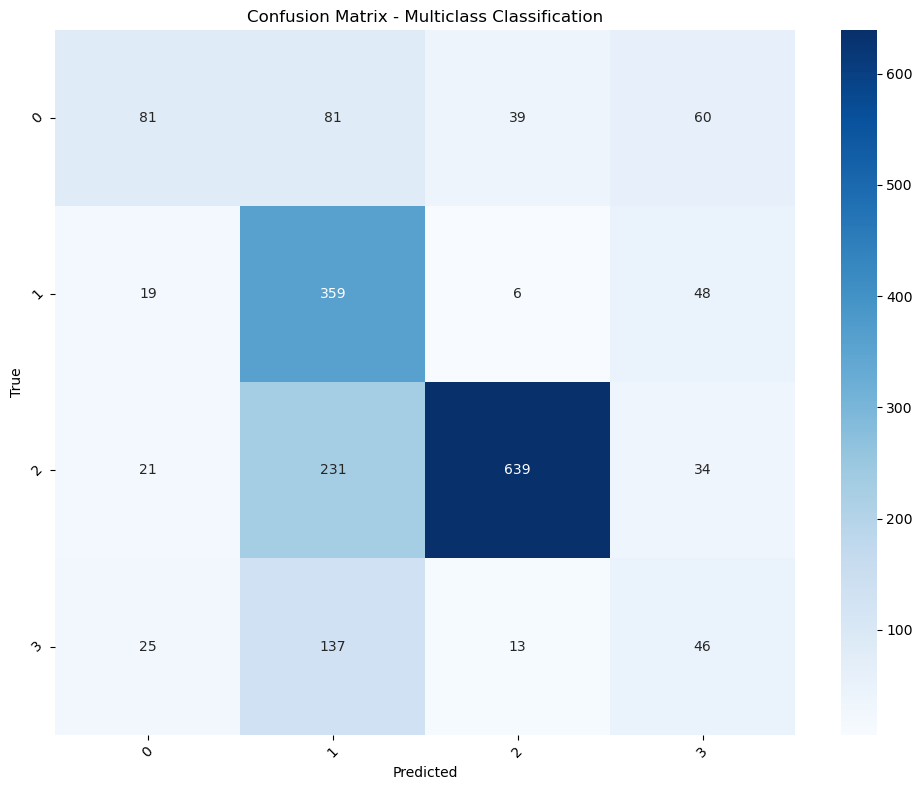

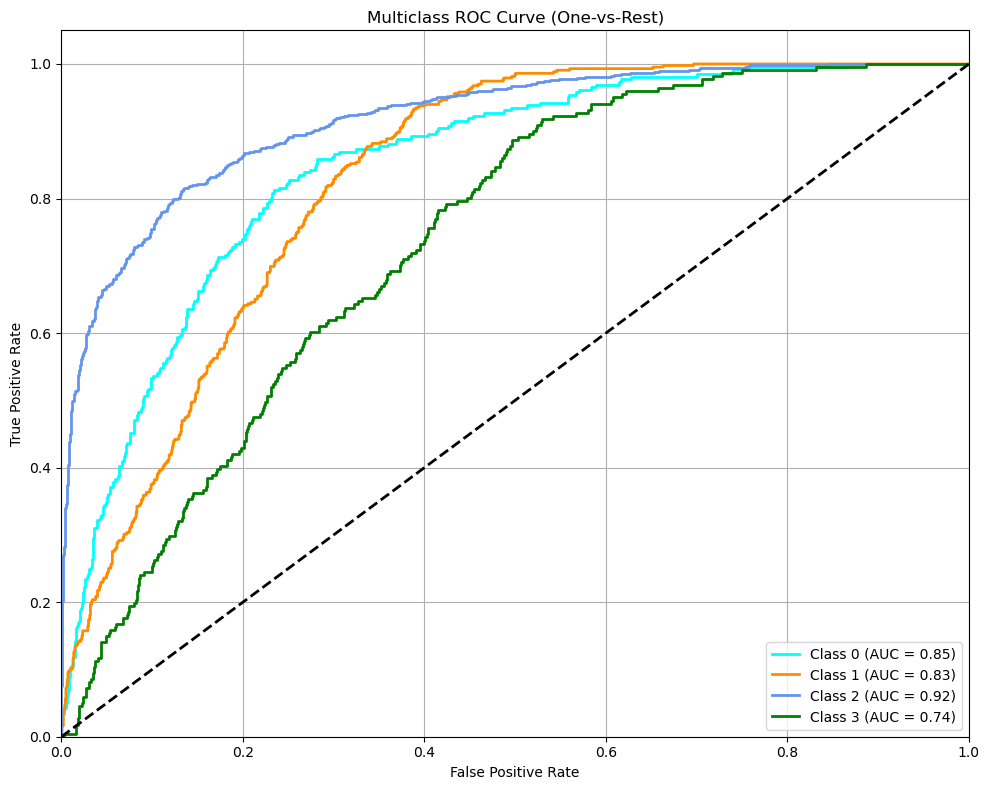

In [67]:


# ───────────────────────────────────────────────
# Binary Model Evaluation
# ───────────────────────────────────────────────
binary_test_generator.reset()
y_prob_bin = final_binary.predict(binary_test_generator).ravel()
y_pred_bin = (y_prob_bin > 0.5).astype(int)
y_true_bin = binary_test_generator.classes
labels_bin = list(binary_test_generator.class_indices.keys())

# Classification Report
print("\nBinary Test Classification Report:")
print(classification_report(y_true_bin, y_pred_bin, target_names=labels_bin))

# Confusion Matrix
cm_bin = confusion_matrix(y_true_bin, y_pred_bin)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels_bin, yticklabels=labels_bin)
plt.title('Confusion Matrix - Binary Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# ROC Curve & AUC
fpr_bin, tpr_bin, _ = roc_curve(y_true_bin, y_prob_bin)
roc_auc_bin = auc(fpr_bin, tpr_bin)

plt.figure(figsize=(6, 5))
plt.plot(fpr_bin, tpr_bin, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc_bin:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Binary Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Multiclass Model Evaluation

multi_test_generator.reset()
y_prob_multi = final_multi.predict(multi_test_generator)
y_pred_multi = np.argmax(y_prob_multi, axis=1)
y_true_multi = multi_test_generator.classes
labels_multi = list(multi_test_generator.class_indices.keys())

# Classification Report
print("\nMulticlass Test Classification Report:")
print(classification_report(y_true_multi, y_pred_multi, target_names=labels_multi))

# Confusion Matrix
cm_multi = confusion_matrix(y_true_multi, y_pred_multi)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_multi, yticklabels=labels_multi)
plt.title('Confusion Matrix - Multiclass Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# ROC AUC Curve (Multiclass - One-vs-Rest)
y_true_multi_bin = label_binarize(y_true_multi, classes=np.arange(len(labels_multi)))
n_classes = y_true_multi_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_multi_bin[:, i], y_prob_multi[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'olive'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {labels_multi[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


### Generalizability

- To ensure that the models were robust and were able to generalise, the data was split into training, validation and test.
- The validation set was used during the model tuning and guided decisions based on the performance, such as with early stopping and regularisation.
The test data was used at the end for the final models to evaluate how the models are able to generalise to unseen data.
- The models were trained using data augmentation, L2 regularisation and dropout, and were monitored using early stopping to prevent any overfitting to improve the robustness of the model.

| Metric (Weighted Average)        | cellType (Validation) | cellType (Test) | isCancerous (Validation) | isCancerous (Test) |
| ------------- | --------------------- | --------------- | ------------------------ | ------------------ |
| **F1-Score**  | 0.65                  | 0.62            | 0.85                     | 0.85               |
| **Precision** | 0.71                  | 0.67            | 0.85                     | 0.85               |
| **Recall**    | 0.64                  | 0.61           | 0.85                     | 0.85               |


- Based on the table above, the isCancerous model showed consistent and strong performance across both validation and test sets, with F1-Score, precision, and recall remaining the same demonstrating strong generalisation to the unseen data.
- The cellType model had moderate but stable generalisation, with macro F1-score decreasing slightly from 0.65 (validation) to 0.62 (test). Precision and recall followed a similar trend, showing the model handled the complexity and class imbalance reasonably well.
- The small gap between validation and test performance across cellType confirms that there was no significant loss in generalisability, and the model remained robust when evaluated on unseen data.
- For both models the regularisation, augmentation, class weighting and other methods were all important in being able to allow the model to learn patterns and predict data strongly.

#### Extra and Main data csv for cellType

In [71]:
# 1. Predict cell types for df_extra

extra_generator = ImageDataGenerator(rescale=1./255, data_format='channels_last').flow_from_dataframe(
    dataframe=df_extra,
    directory=img_dir,
    x_col='ImageName',    
    y_col=None,
    target_size=(27, 27),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

df_extra['cellType'] = np.argmax(final_multi.predict(extra_generator), axis=1)
df_extra['isCancerous'] = '0'  # Placeholder

# Merge with main data and save
df_combined = pd.concat([df_main, df_extra], ignore_index=True)
df_combined.to_csv('combined_data_with_predictions.csv', index=False)

Found 10384 validated image filenames.
  6/325 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step 

C:\Users\azhar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


Found 23192 validated image filenames belonging to 4 classes.
Found 3245 validated image filenames belonging to 4 classes.
Found 4056 validated image filenames belonging to 4 classes.


C:\Users\azhar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Best L2 lambda: 0.0001 → val_precision: 0.960
Epoch 1/27
725/725 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 1.1901 - precision: 0.8118 - recall: 0.8234 - val_loss: 0.7568 - val_precision: 0.9448 - val_recall: 0.9074
Epoch 2/27
725/725 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - loss: 0.8667 - precision: 0.8780 - recall: 0.8696 - val_loss: 0.6357 - val_precision: 0.9378 - val_recall: 0.9703
Epoch 3/27
725/725 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - loss: 0.7962 - precision: 0.8857 - recall: 0.8846 - val_loss: 1.1486 - val_precision: 0.9065 - val_recall: 0.9110
Epoch 4/27
725/725 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - loss: 0.7775 - precision: 0.8907 - recall: 0.8975 - val_loss: 0.5727 - val_precision: 0.9505 - val_recall: 0.9572
Epoch 5/27
725/725 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - loss: 0.7538 - precision: 0.8918 - recall: 0.8933 - val_loss: 0.7142 - val_precision: 0.9481 - val_recall: 0.9110
Epoch 6/27
725/725 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - loss: 0.7318 - precision: 0.8974 - recall: 0.902

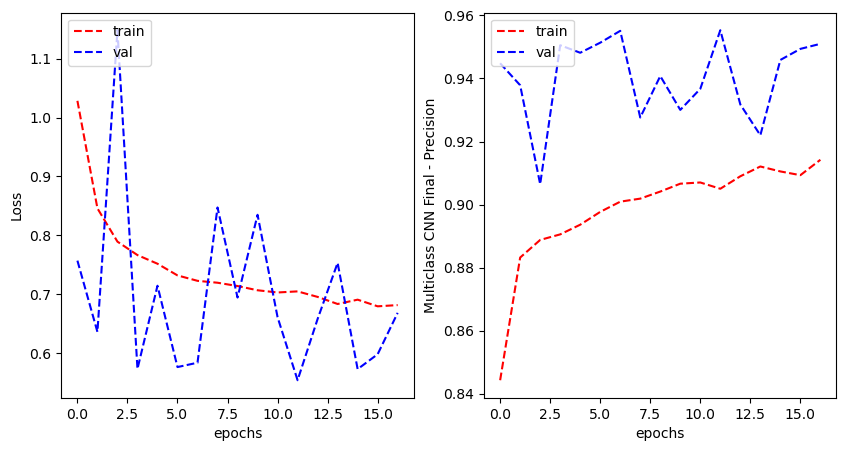

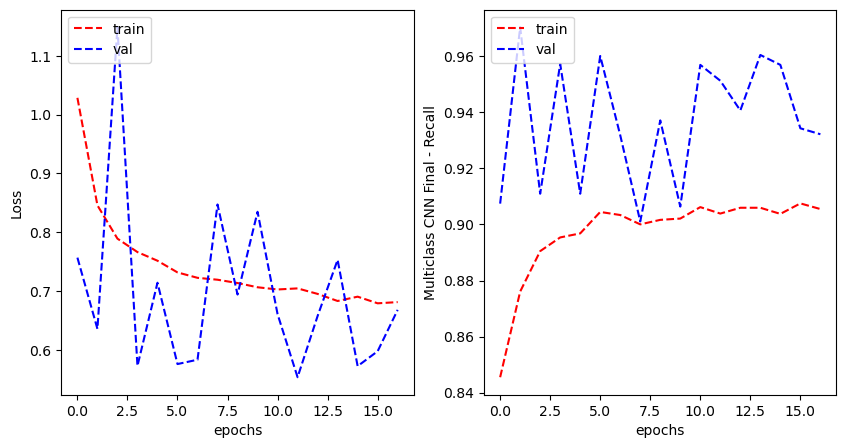

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       519
           1       0.81      0.86      0.83      1413
           2       0.95      0.84      0.89      1812
           3       0.45      0.60      0.51       312

    accuracy                           0.81      4056
   macro avg       0.72      0.75      0.73      4056
weighted avg       0.83      0.81      0.82      4056

y_true: 4056
y_pred: 4056


In [72]:

# ─── 1) Split into train/val/test ─────────────────────────
df_combined['cellType'] = df_combined['cellType'].astype(str)
trainval_df, test_df = train_test_split(
    df_combined,
    test_size=0.2,
    stratify=df_combined['cellType'],
    random_state=42
)
train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.2,
    stratify=trainval_df['cellType'],
    random_state=42
)

# ─── 2) Compute class weights ─────────────────────────────
y_train = train_df['cellType']
class_names = np.unique(y_train)
weights = class_weight.compute_class_weight('balanced', classes=class_names, y=y_train)
class_weights_multi = dict(zip(class_names, weights))

# ─── 3) Oversample minority classes on-the-fly DataFrame ──
counts = train_df['cellType'].value_counts()
max_count = counts.max()
oversampled = [train_df]
for cls, cnt in counts.items():
    if cnt < max_count:
        dfc = train_df[train_df['cellType'] == cls]
        oversampled.append(dfc.sample(max_count - cnt, replace=True, random_state=42))
train_multi_balanced = pd.concat(oversampled).reset_index(drop=True)

# ─── 4) Data Generators ───────────────────────────────────
batch_size = 32
target_size = (27, 27)

train_aug = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.1
)
val_test_gen = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_dataframe(
    dataframe=train_multi_balanced,
    directory=img_dir,
    x_col='ImageName',
    y_col='cellType',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
val_gen = val_test_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=img_dir,
    x_col='ImageName',
    y_col='cellType',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_gen = val_test_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=img_dir,
    x_col='ImageName',
    y_col='cellType',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# ─── 5) Model builder (reg_lambda tunable) ────────────────
def create_multi_cnn(reg_lambda, num_classes):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(27,27,3)),
        tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=[
            GlobalPrecision(name='precision'),
            GlobalRecall(name='recall')
        ]
    )
    return model

# ─── 6) Hyperparameter tuning for L2 lambda ──────────────
reg_list = [1e-5, 1e-4, 5e-4, 1e-3, 5e-3]
best_lambda, best_prec = None, 0.0
num_classes = df_combined['cellType'].nunique()

for reg in reg_list:
    m = create_multi_cnn(reg, num_classes)
    hist = m.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5,
        class_weight=class_weights_multi,
        callbacks=[EarlyStopping(monitor='val_precision', patience=3, restore_best_weights=True)],
        verbose=0
    )
    val_prec = max(hist.history['val_precision'])
    if val_prec > best_prec:
        best_prec, best_lambda = val_prec, reg

print(f"Best L2 lambda: {best_lambda} → val_precision: {best_prec:.3f}")

# ─── 7) Final training with best lambda ────────────────────
final_model = create_multi_cnn(best_lambda, num_classes)
history = final_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=27,
    class_weight=class_weights_multi,
    callbacks=[EarlyStopping(monitor='val_precision', patience=5, restore_best_weights=True)],
    verbose=1
)

# ─── 7.5) Plot Learning Curves for Precision and Recall ───
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['precision'],
    history.history['val_precision'],
    metric_name='Multiclass CNN Final - Precision'
)

plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['recall'],
    history.history['val_recall'],
    metric_name='Multiclass CNN Final - Recall'
)

# ─── 8) Evaluation on test set ─────────────────────────────
test_gen.reset()
y_pred = np.argmax(final_model.predict(test_gen), axis=1)
y_true = test_gen.classes
labels = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))


# GPT 
# Reset to ensure generator starts from beginning
test_gen.reset()

# Predict the entire dataset
y_prob = final_model.predict(test_gen, steps=len(test_gen), verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# Get true labels
y_true = test_gen.classes

# Sanity check
print("y_true:", len(y_true))
print("y_pred:", len(y_pred))
assert len(y_true) == len(y_pred), "Mismatch in prediction length!"

Confusion matrix sum: 4056


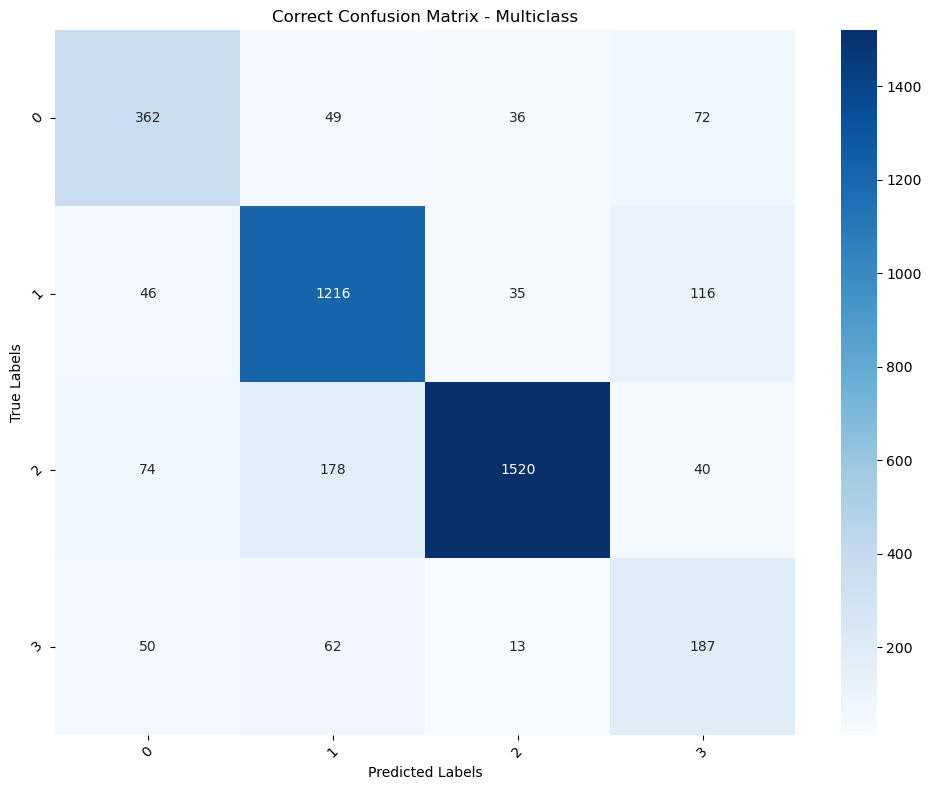

4056 4056


In [73]:

labels = list(test_gen.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

# Confirm sum
print(f"Confusion matrix sum: {np.sum(cm)}")  # Should be 4056

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Correct Confusion Matrix - Multiclass')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


print(len(y_true), len(y_pred))  # should both print 4056

| Metric (Weighted Average)        | cellType on Validation Data (Old Dataset) | cellType on Test Data (Old Dataset) | cellType on Test Data (New Dataset) |
| ------------- | --------------------- | ------------------- | ------------------- |
| **F1-Score**  | 0.65                  | 0.62                | 0.82                |
| **Precision** | 0.71                  | 0.67                | 0.83                |
| **Recall**    | 0.64                  | 0.61                | 0.81                |

- As observed in the table above the cellType performances significantly better compared to the previous dataset, this is because deep learning models performance increase exponentially when more data is fed to it.
- The F1-score increased from 0.62 to 0.82 , with significant corresponding gains in precision and recall, indicating that the model is now more accurate and better at correctly identifying all classes.

# 2. Independent Evaluation

## 2.1 Comparative Analysis

**Comparison with Baseline Models**

| Metric (Weighted Average) | cellType (Validation) | Baseline cellType (Validation) |  isCancerous (Validation) | Baseline isCancerous (Validation) |
| ------------- | --------------------- | --------------- | ------------------------ | ------------------ |
| **F1-Score**  | 0.65                  | 0.68            | 0.85                     | 0.82              |
| **Precision** | 0.71                  | 0.67            | 0.85                     | 0.82               |
| **Recall**    | 0.64                  | 0.68           | 0.85                     | 0.82               |

**cellType**
- Interestingly out of the 3 metrics only precision iimproved, while F1-Score and recall dropped slightly (~0.03-0.04) suggesting that the model is conservative and predicts only when it is confident. This might be due to the regularisation which penalises the overfitting.

**isCancerous**
- Across all metrics as shown in the table, the secondary model performs better, demonstrating that the enhancements (dropout, L2 regularisation, and early stopping) helped the model generalise better.

**Comaparison with Literature**

**cellType**

- The study "Locality Sensitive Deep Learning for Detection and Classification of Nuclei in Routine Colon Cancer Histology Images" (Sirinukunwattana et al., 2016) introduced a Spatially Constrained Convolutional Neural Network (SC-CNN) coupled with a Neighbouring Ensemble Predictor (NEP) for nucleus detection and classification. The paper achieved a weighted average F1-score of 0.784, which was for softmax CNN + NEP, which yielded the highest based on table 3 within the academic paper. While the weighted F1-score for the cellType model after semi-supervised learning yielded 0.82 (on new dataset).
- The improved performance of our cellType model could be attributed to modern training techniques. As we made use of regularisation methods such as dropout and L2, which helped to prevent overfitting. In addition, we applied data augmentation and balanced the data using oversampling and class weighting. This increased the robustness and performance of the cellType model.
- Despite using a more standard CNN architecture, our model was able to outperform the CNN + NEP model slightly. As the methods that we applied are newer and have since had improvements since the paper was published in 2016, possibly leading to the improvement in F1-score.
- From a different paper, their model includes a softmax CNN with data augmentation for the test data has an F1 score of 0.775 (Babu et al., 2024). It was slightly worse compared to the 0.82 of our model. This could mainly be attributed to the fact that there was no hyperparameter tuning done, only data augmentation was implemented.
  
**isCancerous**
- Based on the models provided in the paper, the closest would be the RCCNet (Ibrahim et al., 2024). As both the isCancerous model and RCCNet are both CNN built and share several core features, such as lightweight structure, no residual connections, and use of standard activation and pooling layers.
| Metric    | **isCancerous (Weighted)** | **isCancerous (Macro)** | **RCCNet \[12]** |
| --------- | ---------------------------- | ---------------- |---------------- |
| F1-Score  | 0.85                         | 0.85     |**0.7887**       |
| Precision | 0.85                         | 0.85 | n/a       |
| Recall    | 0.85                         | 0.85 | n/a       |
- Comparing the performances, the isCancerous model outperforms the RCCNet model as shown in the table above by about ~0.05. This is likely due to enhancements such as dropout, L2 regularisation, and data augmentation. As well as oversampling or class weighting ,which RCCNet may not have incorporated in the training pipeline of its model. Showing the RCCNet model could implement to achieve better performance.

| Metric    | **Your CNN (isCancerous)** | **RCCNet \[12]** |
| --------- | ---------------------------- | ---------------- |
| Accuracy  | 87%                          | **80.6%**        |
| F1-Score  | 0.87                         | **0.7887**       |
| Precision | 0.87                         | – (not reported) |
| Recall    | 0.87                         | – (not reported) |
- Comparing the performances the isCancerous model outperformans the RCCNet model as shown in the table above. This is likely due to the enhancement such as dropout, L2 regularization, and data augmentation. As well as, oversampling or class weighting which RCCNet may have not incorporated in the training pipline of its model.


## 2.2 Critical Discussion on Semi-Supervised Learning

**Definition:**

Semi-supervised learning is a machine learning approach that leverages a small amount of labeled data along with a large pool of unlabeled data to improve model performance. It lies between supervised and unsupervised learning and is particularly useful when labeling data is expensive or time-consuming.

**Application to This Project:**

In this project, the df_extra dataset contains unlabeled cell images. We used the predictions from a previously trained classifier (final_multi) to assign pseudo-labels to these images, effectively converting them into labeled data. By merging df_extra with the original labeled dataset (df_main), we applied semi-supervised learning to expand the training set and enhance generalization.

**Strengths and Limitations:**

The strength of this approach is that it allows us to utilize a larger dataset without requiring manual annotation, which can lead to better model performance. However, a limitation is the risk of error propagation: if the pseudo-labels are incorrect, the model may reinforce its own mistakes, especially if the initial classifier is not highly accurate. This could negatively impact learning if not controlled.

**Real-world Use Cases:**

Semi-supervised learning is commonly used in medical imaging, where expert annotations are expensive, and natural language processing, where labeling large corpora is time-consuming. It's also used in speech recognition, fraud detection, and self-driving cars where massive data is available but only a subset is labeled.

**Boosting Task Performance:**

By incorporating unlabeled data, semi-supervised learning enables the model to learn underlying data distributions more effectively, often leading to improved generalization and accuracy—especially in domains where labeled data is limited but unlabeled data is plentiful, as in this project.

## Appendix

## References
- K. Sirinukunwattana, S. E. A. Raza, Y. Tsang, D. R. J. Snead, I. A. Cree
and N. M. Rajpoot, ”Locality Sensitive Deep Learning for Detection and
Classification of Nuclei in Routine Colon Cancer Histology Images,” in
IEEE Transactions on Medical Imaging, vol. 35, no. 5, pp. 1196-1206,
May 2016, doi: 10.1109/TMI.2016.2525803.
- Ibrahim, D. M., Hammoudeh, M. A. A., & Allam, T. M. (2024). Histopathological cancer detection based on deep learning and stain images. Indonesian Journal of Electrical Engineering and Computer Science, 36(1), 214–230. https://doi.org/10.11591/ijeecs.v36.i1.pp214-230
- Babu, K.K., Reddy, B.S., Chimma, A., Pranav, P., Kumar, K.S. (2024). Colon Cancer Nuclei Classification with Convolutional Neural Networks. In: Garg, D., Rodrigues, J.J.P.C., Gupta, S.K., Cheng, X., Sarao, P., Patel, G.S. (eds) Advanced Computing. IACC 2023. Communications in Computer and Information Science, vol 2054. Springer, Cham. https://doi.org/10.1007/978-3-031-56703-2_30